# Trying to fit to the MSSFR from TNG

In [1]:
import h5py as h5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u
from astropy import constants as const
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

from scipy import interpolate
from scipy.optimize import minimize
from scipy.optimize import curve_fit

from astropy.cosmology import WMAP9, z_at_value
from astropy.cosmology import Planck18  as cosmo# Planck 2018
from astropy.cosmology import z_at_value

from astropy.table import Table, Column
import os

import matplotlib
from pylab import *
from matplotlib import ticker, cm

def Mchirp(m1, m2):
    chirp_mass = np.divide(np.power(np.multiply(m1, m2), 3./5.), np.power(np.add(m1, m2), 1./5.))
    return chirp_mass    
   
save_loc    =  '/Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/'
    
proj_dir    = '/Volumes/TOSHIBA_EXT/'#'/n/de_mink_lab/Users/lvanson/'
base_dir    = proj_dir+'/CompasOutput/'
data_dir    = base_dir+ '/v02.17.18/N1e6_CoolWind_fWR_LBV/'#'/N1e6_CoolWind_fWR/'#'/N1e5_fWR_CoolWind_LBVpresc/'  #'N1e5_fWR_allWind/'#'Ne7Grid_alpha01_10_fWR01_10/'

TNGlocation = '/Users/lieke/surfdrive/Documents/CompareCOMPAS/'

plt.rc('font', family='serif')

##PLOT setttings
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,20,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize




# SFR(z) Madau & Dickenson 2014 shape

In [2]:

########################################################
##
########################################################
def Madau_Dickinson2014(z, a=0.015, b=2.77, c=2.9, d=5.6):
    """
    Args:
        z             --> [list of floats] List of redshifts at which to calculate things
        a,b,c,d       --> [floats] values to determine the shape of our SFR
    
    Calculates the star-formation rate density as a function of redshift
    Based on the functional form from Madau & Dickinson 2014
    default 'Neijssel et al 2019': a=0.01, b=2.77, c=2.9,  d=4.7
    Madau & Dickinson 2014: a=0.015, b=2.7, c=2.9,  d=5.6
    Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2

    Returns:
        SFR(z) in Msun/yr/Mpc^3

    """
    dm_dtdMpc = a * (1 + z)**b/( 1 + ( (1+z)/c )**d ) *u.Msun *u.yr**-1 *u.Mpc**-3
    return dm_dtdMpc # Msun year-1 Mpc-3 

    

    

# Get dP/dZ(z)

### New log skewed distribution

metallicity density distribution
Basically this tells us what the probability of finding a certain metallicity at a certain redshift is. 

See also eq. 17 in : https://arxiv.org/ftp/arxiv/papers/1501/1501.02344.pdf


# (log) Skew normal dist: 

PDF of the skew normal is defined as:

\begin{equation}
f(Z) = 2 \phi \left(\frac{Z - \mu}{\sigma}\right) \Phi\left(\alpha \frac{Z - \mu}{\sigma} \right)
\end{equation}

$\phi(t)$ and $\Phi(t)$ are the standard ($\sigma = 1$) normal PDF and CDF respectively:

The skew normal is a generalization of the normal distribution, that gets back to a normal distribution for $\alpha = 0$.


***
The PDF for the **log-skew-normal** are then given by just substituting the random variable Z, with ln(Z)


\begin{equation}
f(Z) = 2 \phi(\frac{ln(Z) - \mu}{\sigma}) \Phi(\alpha \frac{ln(Z) - \mu}{\sigma})
\end{equation}

or written out explicitely:

\begin{equation}
f(Z) = \frac{2}{Z \sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{\ln(Z) - \mu}{\sigma}\right)^2} 
\int_{-\infty}^{x = \left(\alpha \frac{\ln(Z) - \mu}{\sigma} \right) } \frac{1}{\sqrt{2 \pi}} e^{\frac{-1}{2}t^2} dt
\end{equation}

or

\begin{equation}
f(Z) = \frac{2}{Z \sigma \sqrt{2 \pi}} e^{\frac{-1}{2} \left(\frac{\ln(Z) - \mu}{\sigma}\right)^2} 
\frac{1}{2} \left[ 1 + erf\left(\frac{ \left(\alpha \frac{\ln(Z) - \mu}{\sigma} \right)  }{\sqrt{2}} \right) \right]
\end{equation}


The extra $1/Z$ factors in front of the PDFs come from 
\begin{equation}
\frac{dP}{dZ} = \frac{dP}{d\ln Z} \frac{d\ln Z}{dZ} = \frac{dP}{d\ln Z} \frac{1}{Z}
\end{equation}

***

## Moments
Moments of a probability distribution: the zeroth moment is the total probability (i.e. one), the first moment is the expected value, the second central moment is the variance, the third standardized moment is the skewness, and the fourth standardized moment is the kurtosis. 

equation 23) and 24) from : https://arxiv.org/ftp/arxiv/papers/1501/1501.02344.pdf
give the mean and variance of our log-skew-normally distributed random variable Z:


\begin{equation}
E(Z) = 2 e^{\mu} e^{\sigma^2 /2} \Phi(\beta \sigma)
\end{equation}


\begin{equation}
VAR(Z) = 2 e^{2\mu} e^{\sigma^2} (e^{\sigma^1} \Phi(2 \beta \sigma)  - 2\Phi(\beta \sigma)^2)
\end{equation}


with 
\begin{equation}
\beta = \frac{\alpha}{\sqrt{1 + \alpha^2} }
\end{equation}



In [6]:
def skew_metallicity_distribution(max_redshift = 10.0,redshift_step = 0.01,
                                  mu_0=0.025, muz=-0.048, sigma_0=1.125, sigma_z=0.048,alpha = -1.767,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                  metals = [], redsh = [],
                                  min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)):
                                 
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    the log-normal distribution is a special case of this log skew normal distribution distribution, and is retrieved by setting 
    the skewness to zero (alpha = 0). 
    Based on the method in Neijssel+19. Default values of mu0=0.035, muz=-0.23, sigma_0=0.39, sigma_z=0.0, alpha =0.0, 
    retrieve the dP/dZ distribution used in Neijssel+19

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution!

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu0    = 0.025    --> [float]           location (mean in normal) at redshift 0
        muz    = -0.05    --> [float]           redshift scaling/evolution of the location
        sigma_0 = 1.25     --> [float]          Scale (variance in normal) at redshift 0
        sigma_z = 0.05     --> [float]          redshift scaling of the scale (variance in normal)
        alpha   = -1.77    --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ (influences normalization)
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ (influences normalization)
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """
    import scipy

    ##################################
    # the PDF of a standard normal distrtibution
    def normal_PDF(x):
        return 1./(np.sqrt(2* np.pi)) * np.exp(-(1./2) * (x)**2 )

    ##################################
    # the CDF of a standard normal distrtibution
    def normal_CDF(x):
        return 1./2. * (1 + scipy.special.erf(x/np.sqrt(2)) )
    
    ##################################
    if len(redsh) == 0:
        # Make redshifts
        redshifts = np.arange(0, max_redshift + redshift_step, redshift_step)
    else:
        redshifts = redsh
        
    ##################################
    # Experiment with redshift dependence sigma
    # LOG-LINEAR
    sigma = sigma_0* 10**(sigma_z*redshifts)
    #  LINEAR   sigma = sigma_z*redshifts + sigma_0
    
    ##################################
    # Follow Langer & Norman 2007? in assuming that mean metallicities evolve in z as:
    mean_metallicities = mu_0 * 10**(muz * redshifts) 
    #print('np.shape(mean_metallicities)', np.shape(mean_metallicities))
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    PHI  = normal_CDF(beta * sigma) # phi is now sigma x alpha dimentional 
    mu_metallicities = np.log(mean_metallicities/2. * 1./(np.exp(0.5*sigma**2) * PHI )  ) 

    ##################################
    if len(metals) == 0:
        # create a range of metallicities (thex-values, or raandom variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities = np.exp(log_metallicities)
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)
        step_logZ         = step_logZ[0]
        #print('step_logZ', step_logZ)

    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    dPdlogZ = 2./(sigma[:,np.newaxis]) * normal_PDF((log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis]) * normal_CDF(alpha * (log_metallicities -  mu_metallicities[:,np.newaxis])/sigma[:,np.newaxis] )
    #print('np.shape(dPdlogZ)', np.shape(dPdlogZ))

    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) #* step_logZ
    dPdlogZ = dPdlogZ /norm[:,np.newaxis]

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity



# First read the TNG data 
## And convert it to a SFDR in Msun/yr/Mpc^-3



In [7]:

######################################
# read TNG data
######################################
with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
    MetalBins     = f["MetalBins"][:]
    Lookbacktimes = f["Lookbacktimes"][:]
    BoxSfr        = f["Sfr"][:]
# Convert SFR from sfr/box to sfr Mpc-3
littleh  = 0.6774
Rbox     = 75/littleh
TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
TNG_SFRD = TNG_SFRD.value

##########################################
# "observed" TNG metallicities that we use for our calculations
##########################################
center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
# Let's not use ALL metallicities in the TNG.. (they go waay too low!)
low_bound_Z_ind = np.where(center_Zbin > 1e-5)[0]# index of center_Zbin, where Z > 1e-5
tofit_TNG_metals = center_Zbin[low_bound_Z_ind]   


##########################################
# "obesrved" SFRD in TNG
##########################################
# flip redshifts around so they are in increasing order
TNG_SFRD_inc_z = TNG_SFRD[::-1, :]
tofit_TNG_SFRD = TNG_SFRD_inc_z[:,low_bound_Z_ind] 


##########################################
# The redshifts at which we will calc the log-skew-normal
##########################################
#### TNG redshifts corresponding to these lookback times ### 
# the last value of Lookbacktimes = 0, which is problematic for z calculation
redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
redshifts_TNG.append(0) # put redshift zero back at the end
redshifts_TNG = np.array(redshifts_TNG)
print('redshifts_TNG')  
print(['%.2f'% (z_fl) for  z_fl in redshifts_TNG[::-1] ] )
# print(np.diff(redshifts_TNG[::-1]), min(np.diff(redshifts_TNG[::-1])), max(np.diff(redshifts_TNG[::-1])))
    
reverse_lookback = Lookbacktimes[::-1]
# print('Reverse_lookback time: ')
# print(['%.2f'% (t_l) for  t_l in reverse_lookback ] )
# print(np.diff(reverse_lookback), min(np.diff(reverse_lookback)), max(np.diff(reverse_lookback)))


redshifts_TNG
['0.00', '0.01', '0.02', '0.03', '0.05', '0.06', '0.07', '0.08', '0.10', '0.11', '0.13', '0.14', '0.15', '0.17', '0.18', '0.20', '0.21', '0.23', '0.24', '0.26', '0.27', '0.30', '0.31', '0.33', '0.35', '0.36', '0.38', '0.40', '0.42', '0.44', '0.46', '0.48', '0.50', '0.52', '0.55', '0.58', '0.60', '0.62', '0.65', '0.68', '0.70', '0.73', '0.76', '0.79', '0.82', '0.85', '0.89', '0.92', '0.95', '1.00', '1.04', '1.08', '1.12', '1.16', '1.21', '1.25', '1.31', '1.36', '1.42', '1.50', '1.54', '1.61', '1.67', '1.75', '1.83', '1.91', '2.01', '2.11', '2.22', '2.33', '2.46', '2.59', '2.75', '2.91', '3.03', '3.31', '3.52', '3.74', '4.05', '4.22', '4.48', '4.72', '5.06', '5.30', '5.61', '5.94', '6.11', '6.62', '7.15', '7.40', '7.78', '8.22', '8.68', '9.28', '9.69', '10.35', '11.42', '12.53', '15.96', '22.11']


# Interpolate the TNG data

Using scipy interpolate
https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.interp2d.html

f = interpolate.interp2d(x, y, z)



In [8]:

#########################################
x = Lookbacktimes[::-1] #redshifts_TNG[::-1]
y = tofit_TNG_metals
z = tofit_TNG_SFRD 
print('np.shape(x), np.shape(y), np.shape(z)', np.shape(x), np.shape(y), np.shape(z))

f_interp = interpolate.interp2d(x, y, z.T, kind='cubic')

# lets interpolate at regular redshift intervals
z_new    = np.arange(0, 10, 0.05)
# z_new = np.append(z_new, np.arange(3, 10, 0.01))
xnew     = [cosmo.lookback_time(z).value for z in z_new]
ynew     = tofit_TNG_metals #np.logspace(-5., -0.5, 100)#

SFRDnew = f_interp(xnew,ynew)

print('np.shape(xnew)', np.shape(xnew),'np.shape(ynew)', np.shape(ynew), 'np.shape(SFRDnew)', np.shape(SFRDnew) )


np.shape(x), np.shape(y), np.shape(z) (100,) (30,) (100, 30)
np.shape(xnew) (200,) np.shape(ynew) (30,) np.shape(SFRDnew) (30, 200)


# Lets start calcuatiing chi^2

In [19]:

##################################################
# muz =-0.09, mu0 =0.026, sigma =1.9, alpha=-3.3
##################################################
def calc_chi_square(fit_metals, Redshifts = redshifts_TNG[::-1],  observed_SFRD = tofit_TNG_SFRD,
                    mu_0_list = 0.026, muz_list =-0.09, sigma0_list = 1.9, sigmaz_list = 1.9, alpha_list =-3.3,
                    sf_a =0.01 , sf_b=2.6, sf_c=3.2 , sf_d=6.2, normed = False):
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    that is basically a skew normal distribution, but then with the random variable x = ln(Z)

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution

    Args:
        fit_metals              --> [float]          metals used for fitt
        Redshifts               --> [float]          redshihts used to fit
        observed_SFRD           --> [float]          'observed' SFRD to fit to
        
        mu_0_list    = -0.23    --> [float]          location (mean in normal) at redshift 0
        muz_list = 0.035    --> [float]          redshift evolution of the location
        sigma0_list  = 0.39     --> [float]          Scale at redshift 0 (variance in normal)
        sigmaz_list  = 0.0      --> [float]          redshift evolution of Scale (variance in normal)
        alpha_list   = 0.0      --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        sf_a                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_b                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_c                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)
        sf_d                    --> [float]          SFR(z) parameter (shape of Madau & Dickenson 2014)

    Returns:
        tot_chi_square          --> [float ] 
    """
    
    """
    ######################################

    """  
    print('muz_list', muz_list, 'mu_0_list',mu_0_list, 'sigma0_list',sigma0_list,'sigmaz_list',sigmaz_list, 'alpha_list',alpha_list,
          'sf_a', sf_a, 'sf_b', sf_b, 'sf_c', sf_c, 'sf_d', sf_d)
        
    #####################################
    # Get the SFR
    # Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
    sfr = Madau_Dickinson2014(Redshifts, a=sf_a, b=sf_b, c=sf_c, d=sf_d) # Msun year-1 Mpc-3 

    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    skew_metallicity_distribution(muz = muz_list, mu_0 = mu_0_list,
                                                  sigma_0= sigma0_list, sigma_z=sigmaz_list, alpha = alpha_list, 
                                                  metals=fit_metals, redsh = Redshifts)

    #print('np.shape(fit_metals)', np.shape(fit_metals),'np.shape(dPdlogZ)', np.shape(dPdlogZ))
    
    ######################################
    # For each redshift in the TNG data:
    tot_chi_square = 0
    #np.zeros((len(muz_list), len(mu_0_list), len(sigma_list), len(alpha_list)) )
        
    for redshift_i in range(len(redshifts)):
        #print(redshift_i, 'at redshift', redshifts[redshift_i])
        ######################################
        # Now the SFRD = sfr x dPdZ
        #print('sfr[redshift_i]',sfr[redshift_i])
        SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:] 
        #/p_draw_metallicity# Msun year-1 Mpc-3 

        ###################
        if normed:
            obs_norm = np.sum(observed_SFRD[redshift_i,:])
            obs = observed_SFRD[redshift_i,:]/obs_norm
            #print('np.sum(obs)', np.sum(obs))
            
            #model is normed in logZ, so multiply by logZ-binwidth
            model = dPdlogZ[redshift_i,:] *step_logZ 
            #print('np.sum(model)', np.sum(model).flatten() )

        else:
            obs = observed_SFRD[redshift_i,:] 
            #print('step_logZ', step_logZ)
            model = SFRD.value 
        #print('obs', np.shape(obs) , 'model', np.shape(model) )
        
        ###################
        # Zero values are troublesome in Chi_squared!
        # only fit where obs > 1e-8  
        common_bool = np.logical_and(model > 1e-10, obs > 1e-10)
        model = model[common_bool]
        obs   = obs[common_bool]

        ###################
        # Actual CHI_squared
        #chi_square = ((np.log10(obs) - np.log10(model) )**2)#/np.sum(model) 
        chi_square = ((obs - model )**2)/np.sum(model) 
        #print('chi_square', chi_square, np.sum(chi_square, axis = -1))
        #/np.sum(model)  = divide by the sfr at this redshift
        
        #/sfr[redshift_i].value #/model 
        #print('chi_square', chi_square )
        tot_chi_square += np.sum(chi_square, axis = -1)
        #print('tot_chi_square', np.shape(tot_chi_square), tot_chi_square )


    ######################################
    # Minimum Chi_squared taking all redshift into aaccount
    print(tot_chi_square)
    
    return tot_chi_square
#     return chi_square_matix, muz_list[ind[0]], mu_0_list[ind[1]], sigma_list[ind[2]], alpha_list[ind[3]]


    
    

# Run your chi square calculations

## and leave the refinement up to scipy minimize

In [22]:
#################################################################
## Function wrapper to minimize the Chi_square
#################################################################
def test_chi(x0 = [-0.09, 0.026, 1.9, 0.1, -3.3,0.01, 2.6, 3.2, 6.2] ):

# Interpolated TNG data
    chi_square_matix = calc_chi_square(ynew, Redshifts = z_new, observed_SFRD = SFRDnew.T, 
# Pure TNG data                       #fit_metals=tofit_TNG_metals, Redshifts = redshifts_TNG[::-1], observed_SFRD = tofit_TNG_SFRD, 
                                       muz_list =x0[0], mu_0_list =x0[1],sigma0_list =x0[2], sigmaz_list=x0[3], alpha_list =x0[4],
                                       sf_a =x0[5], sf_b=x0[6], sf_c=x0[7], sf_d=x0[8],
                                       normed = False)

    return chi_square_matix


# BEST GUESS
x0 = np.array([-0.15, 0.026, 1.1, 0.1, -3.3, 0.01, 2.6, 3.2, 6.2])
# FIT
res = minimize(test_chi, x0= x0, method ='nelder-mead')

# BOUNDS=[(-0.3, -0.01), (0.01, 0.035), (0.5, 3.5), (-2.5, -0.1), (0.009, 0.011), (2.5,2.7), (1., 5), (1, 9)] 
# res = minimize(test_chi, x0= x0, method ='Powell', bounds=BOUNDS)

print(res.x)




muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.217930925489746
muz_list -0.1575 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.23026438838679242
muz_list -0.15 mu_0_list 0.0273 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.20877884837832647
muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1550000000000002 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.222886736830359
muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.10500000000000001 alpha_list -3.3 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.22426559441756733
muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.465 sf_a 0.01 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.213219157111515
muz_list -0.15 mu_0_list 0.026 sigma0_list 1.1 sigmaz_list 0.1 alpha_list -3.3 sf_a 0.0105 sf_b 2.6 sf_c 3.2 sf_d 6.2
0.21010998967214273
muz_list -0.15 m

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in true_divide



muz_list -0.14797969420249213 mu_0_list 0.026096345763478697 sigma0_list 1.103550840492589 sigmaz_list 0.09957145028537705 alpha_list -3.3475371427245313 sf_a 0.010185204211024573 sf_b 2.696301243014539 sf_c 3.3185246067871215 sf_d 5.855537861524928
0.166666241530766
muz_list -0.14685730209276557 mu_0_list 0.027016537854300197 sigma0_list 1.1055235296551382 sigmaz_list 0.09933336711058655 alpha_list -3.373946666460381 sf_a 0.010288095439371559 sf_b 2.590913044689283 sf_c 3.3843716105577437 sf_d 5.664170006816554
0.14375968270958359
muz_list -0.14528595313914833 mu_0_list 0.0275248067814503 sigma0_list 1.108285294482707 sigmaz_list 0.0990000506658798 alpha_list -3.410919999690572 sf_a 0.010432143159057338 sf_b 2.521369567033924 sf_c 3.4765574158366146 sf_d 5.396255010224833
0.14462461663647286
muz_list -0.14615892478004686 mu_0_list 0.0272424351552558 sigma0_list 1.1067509806896134 sigmaz_list 0.09918522646849467 alpha_list -3.3903792590071333 sf_a 0.010352116648120793 sf_b 2.718893721

0.07928191342129143
muz_list -0.1257682073018287 mu_0_list 0.03209044464696566 sigma0_list 1.1064710702348939 sigmaz_list 0.09640260011045462 alpha_list -4.119866521958689 sf_a 0.009729477625214804 sf_b 2.298551507392289 sf_c 3.494059389033791 sf_d 4.997102093482326
0.07189072201102413
muz_list -0.12772934571545286 mu_0_list 0.03030270450993844 sigma0_list 1.1122621586660606 sigmaz_list 0.09587982424701616 alpha_list -4.224848523870977 sf_a 0.009497249544173952 sf_b 2.4006981362885496 sf_c 3.461542154750105 sf_d 5.192980455229586
0.07207556867318765
muz_list -0.13001549783073543 mu_0_list 0.030540447540696996 sigma0_list 1.1061301326479596 sigmaz_list 0.0968247733401581 alpha_list -3.9338562848755467 sf_a 0.009077339800969414 sf_b 2.4717547549566166 sf_c 3.620430733769383 sf_d 5.396998696847317
0.08887511336130159
muz_list -0.12773850697615144 mu_0_list 0.03076415735892204 sigma0_list 1.0621051237976742 sigmaz_list 0.09688522656455231 alpha_list -4.209095001430244 sf_a 0.00935660022497

0.0792190692724111
muz_list -0.11257277843843194 mu_0_list 0.0326701057183563 sigma0_list 1.037650214538173 sigmaz_list 0.0909179340292805 alpha_list -4.464566117480413 sf_a 0.008506477036154408 sf_b 2.310578408441427 sf_c 3.738600420320175 sf_d 5.610169702793554
0.061965398508216474
muz_list -0.1137161590683271 mu_0_list 0.033007917553736714 sigma0_list 1.0509657155326044 sigmaz_list 0.09199907685225131 alpha_list -4.435059001979485 sf_a 0.009196630147389346 sf_b 2.255355981510257 sf_c 3.606815263515874 sf_d 5.368285800814277
0.06830564345775145
muz_list -0.12013191038845827 mu_0_list 0.031698830521329005 sigma0_list 1.068574436467777 sigmaz_list 0.0934476172520779 alpha_list -4.296946066755849 sf_a 0.008796163706857983 sf_b 2.355353550264164 sf_c 3.6654529372182094 sf_d 5.456543891579152
0.06288308915387476
muz_list -0.11092695424558177 mu_0_list 0.033338376251551234 sigma0_list 1.0309140049945136 sigmaz_list 0.09205430705449526 alpha_list -4.572645077903666 sf_a 0.008785512777878111

0.05974627048365243
muz_list -0.10553971358850164 mu_0_list 0.03345877878253818 sigma0_list 1.1480256153561426 sigmaz_list 0.08559444343204492 alpha_list -4.256992344804246 sf_a 0.008495416305461717 sf_b 2.3774283608210762 sf_c 3.7735150024493724 sf_d 5.915519513176522
0.06036415714861503
muz_list -0.10815434916495459 mu_0_list 0.033124700463516926 sigma0_list 1.1339759215486456 sigmaz_list 0.0870716346075631 alpha_list -4.273922249378802 sf_a 0.008612750457870291 sf_b 2.362057997036356 sf_c 3.7463611649443243 sf_d 5.812747083924949
0.05933804086322113
muz_list -0.10904479232110138 mu_0_list 0.03275150219900822 sigma0_list 1.1520286415919407 sigmaz_list 0.08718400407022682 alpha_list -4.252852582086291 sf_a 0.008731431336472199 sf_b 2.3540550210054683 sf_c 3.7458895072822336 sf_d 5.747984939486025
0.05835645332752197
muz_list -0.1104412444805095 mu_0_list 0.032260409878696966 sigma0_list 1.1440643630841631 sigmaz_list 0.08777956142849902 alpha_list -4.238618771629701 sf_a 0.00877899050

0.052706110699626774
muz_list -0.10078950206337842 mu_0_list 0.03141024004519505 sigma0_list 1.1093755652413413 sigmaz_list 0.08314212023409212 alpha_list -3.9379800096256723 sf_a 0.00886456191139854 sf_b 2.125189365771364 sf_c 4.213283223045778 sf_d 6.499177301024758
0.05282767958836914
muz_list -0.10062934634953885 mu_0_list 0.031636494265518886 sigma0_list 1.1341588829353086 sigmaz_list 0.08406392993703629 alpha_list -4.064415365578853 sf_a 0.008975338449386028 sf_b 2.1344063051989863 sf_c 4.091488282692343 sf_d 6.230926825064895
0.052407672707857206
muz_list -0.09678858104294574 mu_0_list 0.03142699900966053 sigma0_list 1.130857536360562 sigmaz_list 0.0828023093921526 alpha_list -4.031448751115963 sf_a 0.009182005794345943 sf_b 2.0568528062779006 sf_c 4.186218275552099 sf_d 6.359795166853566
0.052952452223489814
muz_list -0.10489718426057609 mu_0_list 0.03085708804562584 sigma0_list 1.1715196111344506 sigmaz_list 0.08422558415339729 alpha_list -4.003413881404475 sf_a 0.008446750476

0.046164312235212605
muz_list -0.09304071914947212 mu_0_list 0.030088268431207543 sigma0_list 1.1215126549364771 sigmaz_list 0.08247618184472194 alpha_list -3.0890786160223627 sf_a 0.011607970553156714 sf_b 1.716320502363379 sf_c 4.6222151727302965 sf_d 6.4936626213837965
0.045157562158802914
muz_list -0.08915318160931954 mu_0_list 0.032636336746424785 sigma0_list 1.132272525204567 sigmaz_list 0.08244105086191145 alpha_list -3.0953443341646496 sf_a 0.01248294722937576 sf_b 1.7098132468496599 sf_c 4.4782548815901855 sf_d 6.352131258663725
0.046884010683756736
muz_list -0.09221033897822767 mu_0_list 0.031468666550635314 sigma0_list 1.070868062276873 sigmaz_list 0.08364468404562589 alpha_list -2.921678726247909 sf_a 0.012564563819620359 sf_b 1.6533836076729567 sf_c 4.61696141276884 sf_d 6.39613033613808
0.043498251687332935
muz_list -0.10101329727547037 mu_0_list 0.029757272510500407 sigma0_list 1.0713709136617209 sigmaz_list 0.0852515882015778 alpha_list -3.374173760698069 sf_a 0.0105120

0.038162422170067226
muz_list -0.0893459538413752 mu_0_list 0.029697691185971112 sigma0_list 1.0243731135962233 sigmaz_list 0.0826806157572001 alpha_list -2.8507611935276547 sf_a 0.013424989580695046 sf_b 1.5727702876897132 sf_c 4.717180287370045 sf_d 6.27491857592528
0.03803950407196702
muz_list -0.08593315450801964 mu_0_list 0.03040036199342537 sigma0_list 1.012403946293995 sigmaz_list 0.08142886028673865 alpha_list -2.720674124404953 sf_a 0.014509905735490606 sf_b 1.5055191790933895 sf_c 4.6891814010440624 sf_d 6.388390729736313
0.03755841838056995
muz_list -0.0946041660758567 mu_0_list 0.029411858092648853 sigma0_list 0.9911875169936706 sigmaz_list 0.08331153194784213 alpha_list -3.120938161992375 sf_a 0.012949094044290146 sf_b 1.7066967586823023 sf_c 4.502626854352357 sf_d 6.276550228487871
0.04047081550802558
muz_list -0.08759796760490388 mu_0_list 0.030735097615952486 sigma0_list 1.0632997838101999 sigmaz_list 0.08191849202438575 alpha_list -2.8916594541698926 sf_a 0.01352601780

0.03250728273792041
muz_list -0.0808050946856835 mu_0_list 0.028040077838552516 sigma0_list 1.091755394035685 sigmaz_list 0.0753338130334692 alpha_list -2.451825562786196 sf_a 0.015483246023543902 sf_b 1.505718350626589 sf_c 4.716889546054099 sf_d 6.515792215497084
0.03132249545455206
muz_list -0.08039329064825967 mu_0_list 0.027362988038989296 sigma0_list 1.0733336064022134 sigmaz_list 0.0757220901760438 alpha_list -2.447065375424181 sf_a 0.01619767378444089 sf_b 1.4669366706442455 sf_c 4.6805531264129785 sf_d 6.451434059493666
0.030741011154738776
muz_list -0.07912171979859561 mu_0_list 0.026232531276577556 sigma0_list 1.084100941776232 sigmaz_list 0.0744832732999525 alpha_list -2.3959357487427564 sf_a 0.01690770509571794 sf_b 1.45217852596201 sf_c 4.64233523588773 sf_d 6.416948525358823
0.031732681763671174
muz_list -0.07572585369910846 mu_0_list 0.027880395450754138 sigma0_list 1.0637583836799616 sigmaz_list 0.07539862895001934 alpha_list -2.0877713476939057 sf_a 0.0172144708678587

0.028505406171431307
muz_list -0.06931022128209163 mu_0_list 0.02715459019145334 sigma0_list 1.092534969754491 sigmaz_list 0.06729478416673418 alpha_list -2.202613965187232 sf_a 0.01748698964094335 sf_b 1.382722280987505 sf_c 4.751560743596036 sf_d 6.847319637271184
0.02860379496962235
muz_list -0.07245867735495903 mu_0_list 0.02672464504774988 sigma0_list 1.0750861480803318 sigmaz_list 0.06949829967027206 alpha_list -2.3132762001468006 sf_a 0.016753007365957834 sf_b 1.3968552258341533 sf_c 4.805098678211028 sf_d 6.698394619457621
0.026239216755761918
muz_list -0.0707206170033095 mu_0_list 0.026296787720229184 sigma0_list 1.0806885447750458 sigmaz_list 0.06841697226630941 alpha_list -2.283279517379361 sf_a 0.016917455053440736 sf_b 1.3762320498779004 sf_c 4.846341901546413 sf_d 6.691934777629358
0.02535687927559304
muz_list -0.0734197992264083 mu_0_list 0.02672003916982848 sigma0_list 1.0611322127302973 sigmaz_list 0.06954058878614583 alpha_list -2.4415327543133936 sf_a 0.0162939038776

0.019816378756077703
muz_list -0.050577783507589846 mu_0_list 0.023337430193873507 sigma0_list 1.1891950229202592 sigmaz_list 0.05688436931775054 alpha_list -2.12581476077024 sf_a 0.019197027948033255 sf_b 1.2746480047924678 sf_c 4.940993245011496 sf_d 6.47825872477388
0.020871930580755368
muz_list -0.05362779298699885 mu_0_list 0.024364839625680396 sigma0_list 1.133712641400697 sigmaz_list 0.05833473266566863 alpha_list -2.161757964485596 sf_a 0.018589834696086285 sf_b 1.2551132987128413 sf_c 4.9631684712227475 sf_d 6.464911135771995
0.01921798412213427
muz_list -0.04583206486252894 mu_0_list 0.02291617088833703 sigma0_list 1.1526568100651038 sigmaz_list 0.05272652418052831 alpha_list -2.045008729048547 sf_a 0.01941312952893491 sf_b 1.1857525647031633 sf_c 5.058686656039537 sf_d 6.4609519002040265
0.020460617124234977
muz_list -0.05924888151398587 mu_0_list 0.025583172261045714 sigma0_list 1.1282987521838876 sigmaz_list 0.06381355274161454 alpha_list -2.3553409935383325 sf_a 0.0183137

0.018929076588761477
muz_list -0.04886864336246752 mu_0_list 0.024719716493420783 sigma0_list 1.1568416936777846 sigmaz_list 0.05591098882602273 alpha_list -2.2225602335729704 sf_a 0.01932224079697137 sf_b 1.2697305077893888 sf_c 4.834394021201023 sf_d 6.284446792747614
0.017036973869889234
muz_list -0.05099272854645484 mu_0_list 0.024461564378665243 sigma0_list 1.1543929270794733 sigmaz_list 0.05839823780212107 alpha_list -2.2864935796745582 sf_a 0.019603006908135677 sf_b 1.292633694646069 sf_c 4.756047359683043 sf_d 5.943841803938296
0.01736088829084794
muz_list -0.047179341715743575 mu_0_list 0.02417993145644857 sigma0_list 1.1675707339202965 sigmaz_list 0.05410247225505996 alpha_list -2.3137371828055633 sf_a 0.01962435322822422 sf_b 1.2928117514860866 sf_c 4.753905790602994 sf_d 6.12217827237977
0.016940041763039235
muz_list -0.0512298768709198 mu_0_list 0.025611305697861173 sigma0_list 1.1729452672809662 sigmaz_list 0.058512886036566875 alpha_list -2.262348278729301 sf_a 0.0194670

0.016615873597521775
muz_list -0.045697914702668915 mu_0_list 0.02348581149787419 sigma0_list 1.170652208457819 sigmaz_list 0.0534183443335314 alpha_list -2.1876867609180444 sf_a 0.020231463890112572 sf_b 1.2552000809073023 sf_c 4.785751962252542 sf_d 6.1056048364871955
0.016140597864484275
muz_list -0.04482174127026732 mu_0_list 0.023714669275014814 sigma0_list 1.1854788229824922 sigmaz_list 0.05264349452379573 alpha_list -2.158475273940167 sf_a 0.0206563282849501 sf_b 1.269085310301368 sf_c 4.711503182498573 sf_d 6.1098610272249765
0.01607654323278271
muz_list -0.04404368538042186 mu_0_list 0.02371770859233594 sigma0_list 1.188848907721177 sigmaz_list 0.051707652541221116 alpha_list -2.134187286199408 sf_a 0.021024479619659864 sf_b 1.2757015662345954 sf_c 4.658523912234514 sf_d 6.093538302270666
0.016492087044594168
muz_list -0.04193896754326807 mu_0_list 0.02341209550545132 sigma0_list 1.18986629847501 sigmaz_list 0.05142910887493843 alpha_list -2.181979307870269 sf_a 0.020789208396

0.015951295079004297
muz_list -0.0464132031482207 mu_0_list 0.02387383517691826 sigma0_list 1.1722776202529959 sigmaz_list 0.05379755745416653 alpha_list -2.185525700983109 sf_a 0.020390280094188966 sf_b 1.2637285937496212 sf_c 4.728898638227939 sf_d 6.084333830948473
0.015945217852576615
muz_list -0.044771232095907804 mu_0_list 0.02356294389854411 sigma0_list 1.1872528762843202 sigmaz_list 0.05284701127196348 alpha_list -2.191116282998024 sf_a 0.020683347185509942 sf_b 1.2668325937096696 sf_c 4.699638186593743 sf_d 6.02497278739787
0.01599317833122626
muz_list -0.04574947434046557 mu_0_list 0.02357261898096401 sigma0_list 1.1850638721667823 sigmaz_list 0.053490147501129966 alpha_list -2.155709849015448 sf_a 0.020594905672759786 sf_b 1.260199360000953 sf_c 4.729304434961071 sf_d 6.0833512114182735
0.01605032372673202
muz_list -0.0449732200900056 mu_0_list 0.023629182940365735 sigma0_list 1.1784586462476523 sigmaz_list 0.05287140698155364 alpha_list -2.1853596967906217 sf_a 0.0204940738

0.015877772758526136
muz_list -0.045190428693808876 mu_0_list 0.02347024399263789 sigma0_list 1.1832154102935672 sigmaz_list 0.052744753267783655 alpha_list -2.178596227803889 sf_a 0.02057433600183972 sf_b 1.2573028591081463 sf_c 4.726050279272691 sf_d 6.049746687312501
0.01587827700045649
muz_list -0.04500668450626478 mu_0_list 0.023572929364595846 sigma0_list 1.1791448234969937 sigmaz_list 0.05254780008618942 alpha_list -2.1808985071297835 sf_a 0.020539443553672446 sf_b 1.2579679311502656 sf_c 4.727302666455108 sf_d 6.081434957272066
0.015886823340320134
muz_list -0.04652009566503447 mu_0_list 0.023774406618173677 sigma0_list 1.1720370250413072 sigmaz_list 0.053462911877374876 alpha_list -2.1842870919451585 sf_a 0.02041183392685763 sf_b 1.2628312126509293 sf_c 4.722659957915557 sf_d 6.064225470658548
0.015862299437333353
muz_list -0.04611704620752761 mu_0_list 0.023815648183232466 sigma0_list 1.1778372958811192 sigmaz_list 0.05345777345637974 alpha_list -2.201477362058314 sf_a 0.0202

0.015747862265564613
muz_list -0.04586383162426007 mu_0_list 0.023462953250668814 sigma0_list 1.180700271969144 sigmaz_list 0.05113518472258788 alpha_list -2.14511557944455 sf_a 0.02056543808074399 sf_b 1.2512951282984464 sf_c 4.7113271848833405 sf_d 6.05742434733399
0.015704805131833074
muz_list -0.045528125274432105 mu_0_list 0.02373699931091656 sigma0_list 1.183802016936946 sigmaz_list 0.05117086631831393 alpha_list -2.1570139323865565 sf_a 0.02059778932193275 sf_b 1.2639013672004422 sf_c 4.687276518796545 sf_d 6.037200619065661
0.015709325729978643
muz_list -0.04642381927178608 mu_0_list 0.023781562966356945 sigma0_list 1.1823515263327131 sigmaz_list 0.05215566539394323 alpha_list -2.1607790022331628 sf_a 0.02044649649709318 sf_b 1.261884336029706 sf_c 4.7077839974857145 sf_d 6.0393470261841316
0.01567169052098431
muz_list -0.04698064599722811 mu_0_list 0.023948849289567364 sigma0_list 1.1842569729471526 sigmaz_list 0.05263010943940588 alpha_list -2.166028194760333 sf_a 0.020337716

0.015039551591271814
muz_list -0.04946908702888486 mu_0_list 0.02427655449835059 sigma0_list 1.198968531536579 sigmaz_list 0.04560514860133422 alpha_list -2.048422211068482 sf_a 0.01995186651876548 sf_b 1.288034725366674 sf_c 4.635727901283623 sf_d 5.914385363204861
0.014993504217990228
muz_list -0.04847948087936774 mu_0_list 0.024045210560734394 sigma0_list 1.2104760159054941 sigmaz_list 0.045225479467472046 alpha_list -2.039349257608829 sf_a 0.020171834659925898 sf_b 1.2862766666424421 sf_c 4.635331467255941 sf_d 5.853023193241034
0.015204808051566522
muz_list -0.05084179376548384 mu_0_list 0.024272185875386494 sigma0_list 1.1871112047140322 sigmaz_list 0.047667754479360835 alpha_list -2.0557478769986828 sf_a 0.0200606269819968 sf_b 1.286680442289866 sf_c 4.6315262706901805 sf_d 5.86090323503875
0.015029989966738816
muz_list -0.049329189844815664 mu_0_list 0.02399104733691336 sigma0_list 1.201272648532703 sigmaz_list 0.04442693637649539 alpha_list -2.0156314871480374 sf_a 0.020236497

0.014807262758220223
muz_list -0.0536267362492688 mu_0_list 0.025066258680877238 sigma0_list 1.1939592150266094 sigmaz_list 0.04355693370657142 alpha_list -1.976662544704121 sf_a 0.019527351915339282 sf_b 1.3214178476487612 sf_c 4.574478849492531 sf_d 5.852602569721842
0.0147394777040592
muz_list -0.054707623838643735 mu_0_list 0.02526413866776593 sigma0_list 1.1968981662082712 sigmaz_list 0.04156260873106257 alpha_list -1.9373239413495282 sf_a 0.0194099585424502 sf_b 1.33506109771694 sf_c 4.54079240331027 sf_d 5.819387898325516
0.014829474205381587
muz_list -0.0541812978845915 mu_0_list 0.02520511019678268 sigma0_list 1.1812797240353858 sigmaz_list 0.04617492143235601 alpha_list -2.0137029723061213 sf_a 0.019423574307501856 sf_b 1.3169003760804396 sf_c 4.600448860873852 sf_d 5.9170032675046045
0.014716680761386432
muz_list -0.0555698073989189 mu_0_list 0.025493240655060194 sigma0_list 1.1721575104647242 sigmaz_list 0.04692318983947112 alpha_list -2.015189958290545 sf_a 0.0192331819043

0.014559015614717223
muz_list -0.05645235754244987 mu_0_list 0.025167715958050403 sigma0_list 1.18784635058234 sigmaz_list 0.04433337545468456 alpha_list -1.938515020741277 sf_a 0.019270859022170753 sf_b 1.325329788997922 sf_c 4.580092983324905 sf_d 5.877403092908981
0.014640112795975392
muz_list -0.05777637488781586 mu_0_list 0.025787112900525135 sigma0_list 1.1897060294812518 sigmaz_list 0.04352383053583908 alpha_list -1.9471692345135252 sf_a 0.01895317561288743 sf_b 1.351872241301903 sf_c 4.544550874087585 sf_d 5.856077278908515
0.014521033742487113
muz_list -0.05939754991798317 mu_0_list 0.02613239498399618 sigma0_list 1.1919960117586421 sigmaz_list 0.042545394527507496 alpha_list -1.925224032856411 sf_a 0.018664267410269303 sf_b 1.3672710885687342 sf_c 4.529262193158184 sf_d 5.841200126901381
0.014553876715712826
muz_list -0.054808006502696544 mu_0_list 0.02526493297874033 sigma0_list 1.1905486691640368 sigmaz_list 0.04558025447087041 alpha_list -2.0105344605192355 sf_a 0.01932330

0.014404489810235245
muz_list -0.05945595867622912 mu_0_list 0.025797668684226577 sigma0_list 1.194572975658553 sigmaz_list 0.04287594113552893 alpha_list -1.9028192509397048 sf_a 0.018851508371309993 sf_b 1.3745667866241984 sf_c 4.50679917928248 sf_d 5.8887058770800635
0.014387030464012587
muz_list -0.05850008498695383 mu_0_list 0.025968837406857737 sigma0_list 1.2062982732728127 sigmaz_list 0.042776313886371806 alpha_list -1.9211025558608714 sf_a 0.018858084688825744 sf_b 1.3900126941914936 sf_c 4.4898707585677595 sf_d 5.908806671028204
0.01439403276505301
muz_list -0.05882491659501417 mu_0_list 0.026131316844772653 sigma0_list 1.1993204517662681 sigmaz_list 0.04362376530477544 alpha_list -1.931453081859798 sf_a 0.018710651707046395 sf_b 1.385572952376482 sf_c 4.513200246695984 sf_d 5.930475468265442
0.014351901430213775
muz_list -0.05800246360398696 mu_0_list 0.02573380775474315 sigma0_list 1.1940021167592287 sigmaz_list 0.04455984004583272 alpha_list -1.9662333966537515 sf_a 0.0189

0.014290528585259744
muz_list -0.059428214074639295 mu_0_list 0.02606545453954942 sigma0_list 1.2039007927021879 sigmaz_list 0.04324953902687194 alpha_list -1.9306234071296071 sf_a 0.018541492745293067 sf_b 1.4001251469724152 sf_c 4.502643675683544 sf_d 5.945654833619617
0.01430746306472405
muz_list -0.05962739528308607 mu_0_list 0.02603329572654103 sigma0_list 1.2021596350135266 sigmaz_list 0.04322872789309529 alpha_list -1.9269579412360645 sf_a 0.01855125306102439 sf_b 1.3966853708666942 sf_c 4.505019848988437 sf_d 5.933705975810312
0.014290358530041626
muz_list -0.06039778167819007 mu_0_list 0.02596383480908299 sigma0_list 1.2031776416263065 sigmaz_list 0.042738543197990274 alpha_list -1.919633911645093 sf_a 0.01847872548870929 sf_b 1.4005794302337295 sf_c 4.497704209198815 sf_d 5.902096490181645
0.014294481254615844
muz_list -0.06005334595646458 mu_0_list 0.025979693629574585 sigma0_list 1.2009181560115625 sigmaz_list 0.04339377493580179 alpha_list -1.9323499690934929 sf_a 0.018444

0.014238656411931602
muz_list -0.06065519324418164 mu_0_list 0.025950909101776394 sigma0_list 1.2094077762839692 sigmaz_list 0.04153200391585801 alpha_list -1.9343396938292345 sf_a 0.018101273026622955 sf_b 1.4163529891817603 sf_c 4.4918728382911794 sf_d 5.968324233207202
0.014259094274227892
muz_list -0.05965474848313605 mu_0_list 0.02584051399594267 sigma0_list 1.205807136996937 sigmaz_list 0.04274619324015401 alpha_list -1.951859168629868 sf_a 0.018372056471471478 sf_b 1.3987761353015649 sf_c 4.5106032162230765 sf_d 5.920805015517518
0.014242437299885068
muz_list -0.05987412611782775 mu_0_list 0.025801535260559345 sigma0_list 1.206561762785975 sigmaz_list 0.04328414434344202 alpha_list -1.978376619254528 sf_a 0.01817485689944226 sf_b 1.4081759960448408 sf_c 4.513772265322018 sf_d 5.973311624229982
0.014229991803609976
muz_list -0.05987785544840571 mu_0_list 0.025762784456830973 sigma0_list 1.2076348911678485 sigmaz_list 0.04356379885150424 alpha_list -2.001518908964095 sf_a 0.018052

0.014224856511203336
muz_list -0.05975526224593609 mu_0_list 0.02581472644522089 sigma0_list 1.207737761170543 sigmaz_list 0.042524171979533384 alpha_list -1.956051247903279 sf_a 0.01826987815765148 sf_b 1.4030531002191586 sf_c 4.51126411501213 sf_d 5.935478993612197
0.014231198676758856
muz_list -0.05982912592093566 mu_0_list 0.025809492169814097 sigma0_list 1.2085715720390253 sigmaz_list 0.04289066839692659 alpha_list -1.9811577081711214 sf_a 0.018113197760630723 sf_b 1.4111332205824731 sf_c 4.512652677334143 sf_d 5.970721935397987
0.014221198231269308
muz_list -0.05978264983722717 mu_0_list 0.025764667040362815 sigma0_list 1.2077392940924683 sigmaz_list 0.043139044311590824 alpha_list -1.9781474888307007 sf_a 0.018167076786018865 sf_b 1.40875243077735 sf_c 4.5136351248467825 sf_d 5.973808107029246
0.014226881193360347
muz_list -0.05981580935705709 mu_0_list 0.025827933511371887 sigma0_list 1.2085331141188487 sigmaz_list 0.04265041952993327 alpha_list -1.971981508730793 sf_a 0.018157

0.01422169387496502
muz_list -0.059868995706950465 mu_0_list 0.02574238149301694 sigma0_list 1.208703924906831 sigmaz_list 0.04269698953610922 alpha_list -1.9816542155407388 sf_a 0.01810433731724033 sf_b 1.4106203531422041 sf_c 4.512507886811314 sf_d 5.960664224191685
0.014219044328503332
muz_list -0.059833657021211184 mu_0_list 0.025720075218516374 sigma0_list 1.2095418420406225 sigmaz_list 0.04265322364597503 alpha_list -1.985827911521974 sf_a 0.018070517360963073 sf_b 1.4133589562370508 sf_c 4.511255149587458 sf_d 5.968497000516119
0.014219652890014605
muz_list -0.06017638568884551 mu_0_list 0.0258225114972171 sigma0_list 1.209234274349857 sigmaz_list 0.04262310370618033 alpha_list -1.9816242363058012 sf_a 0.01803590988199546 sf_b 1.415548179396422 sf_c 4.507182170674184 sf_d 5.966291360315941
0.014219801698061205
muz_list -0.05966312127520468 mu_0_list 0.025720421736398533 sigma0_list 1.2094859097174528 sigmaz_list 0.04284470002679897 alpha_list -1.9873594543604316 sf_a 0.018096591

0.014218124321642323
muz_list -0.05972688291491239 mu_0_list 0.025724585392918366 sigma0_list 1.208836758507381 sigmaz_list 0.042810634783232715 alpha_list -1.9852050150020817 sf_a 0.0181017886796034 sf_b 1.4105216253381774 sf_c 4.51435460998973 sf_d 5.9672606830570984
0.014217782949464903
muz_list -0.0597185221706302 mu_0_list 0.02571983356083221 sigma0_list 1.2087436191768002 sigmaz_list 0.04283879903694113 alpha_list -1.9846684215614423 sf_a 0.018102323875548845 sf_b 1.4103250877021631 sf_c 4.515080289049081 sf_d 5.968669534607351
0.014217633129066432
muz_list -0.0596141602810132 mu_0_list 0.025718871397482725 sigma0_list 1.2086540005646618 sigmaz_list 0.04286839674662366 alpha_list -1.985216511891688 sf_a 0.01813345813515921 sf_b 1.408631188092609 sf_c 4.515306622289308 sf_d 5.965551696431445
0.014218032544581524
muz_list -0.059806839356449426 mu_0_list 0.025733207639323744 sigma0_list 1.2087558824071172 sigmaz_list 0.0429119083599281 alpha_list -1.9883665532672226 sf_a 0.018085513

0.014217209101152392
muz_list -0.05965842837885349 mu_0_list 0.025732659113835283 sigma0_list 1.2079151330097129 sigmaz_list 0.04297441488232055 alpha_list -1.9845943397141748 sf_a 0.01811938934708665 sf_b 1.408298683393853 sf_c 4.517275673508472 sf_d 5.964510456249318
0.014216408194148789
muz_list -0.05960353962711695 mu_0_list 0.025735997673506768 sigma0_list 1.2078893587368906 sigmaz_list 0.04293660190092524 alpha_list -1.9831207856011566 sf_a 0.018129673590347464 sf_b 1.4074678364090367 sf_c 4.5177102224996055 sf_d 5.962209876412942
0.014216422190277184
muz_list -0.05975966755598121 mu_0_list 0.025711926980206877 sigma0_list 1.2074730056410223 sigmaz_list 0.043012861340025764 alpha_list -1.9860830859862806 sf_a 0.018098686696935644 sf_b 1.4089045134011684 sf_c 4.517312357301447 sf_d 5.968011624529247
0.014216632291821836
muz_list -0.05979204443316835 mu_0_list 0.02573044014109345 sigma0_list 1.207187124547053 sigmaz_list 0.043093315108233055 alpha_list -1.9882563359736638 sf_a 0.01

0.014214878617895336
muz_list -0.059882418093700165 mu_0_list 0.02573356692248878 sigma0_list 1.2062426292417945 sigmaz_list 0.043037833940525884 alpha_list -1.9836203660694358 sf_a 0.01807668895951184 sf_b 1.4096884072578466 sf_c 4.5174128973983345 sf_d 5.967474025140245
0.014214548557492669
muz_list -0.05996598321516994 mu_0_list 0.025734165669157677 sigma0_list 1.205848786136714 sigmaz_list 0.04302117551597716 alpha_list -1.9828196336726993 sf_a 0.018058653814582548 sf_b 1.4101475550480043 sf_c 4.517286396437674 sf_d 5.9683305694643565
0.014214550246235276
muz_list -0.059800534094885366 mu_0_list 0.025728846666211697 sigma0_list 1.205565567753652 sigmaz_list 0.043093327890103686 alpha_list -1.9827293871900369 sf_a 0.018109666255649588 sf_b 1.4082154659619137 sf_c 4.517821191619413 sf_d 5.967069714903134
0.014214415673273504
muz_list -0.059794465558983545 mu_0_list 0.025725045407779812 sigma0_list 1.2046278220420934 sigmaz_list 0.0431301473150891 alpha_list -1.9812642617023446 sf_a 0

0.01421065583220843
muz_list -0.060140385569674965 mu_0_list 0.0257869750274467 sigma0_list 1.2010794661562723 sigmaz_list 0.043364901831817945 alpha_list -1.9733138001579942 sf_a 0.018047828634964458 sf_b 1.4088183307932525 sf_c 4.519896186024598 sf_d 5.962495381937522
0.014210401358355319
muz_list -0.06008357590156342 mu_0_list 0.02577070064528186 sigma0_list 1.2012543751407208 sigmaz_list 0.043446959167551286 alpha_list -1.9775669946922905 sf_a 0.01805775021995147 sf_b 1.4089943765054853 sf_c 4.520552289802353 sf_d 5.963691623462951
0.014210994157767734
muz_list -0.060002567930173 mu_0_list 0.02578141923981929 sigma0_list 1.2016179176065234 sigmaz_list 0.043343273488403056 alpha_list -1.9729974220559603 sf_a 0.0180913837309866 sf_b 1.4079432000085892 sf_c 4.519120343789757 sf_d 5.964651982989068
0.014209535445506178
muz_list -0.06003470148801046 mu_0_list 0.025805792063131855 sigma0_list 1.2009684190125087 sigmaz_list 0.04335665500910746 alpha_list -1.9681288912225616 sf_a 0.0180967

0.014192205796858728
muz_list -0.06091973769964597 mu_0_list 0.026052179851706533 sigma0_list 1.1930760339670021 sigmaz_list 0.04319345051405028 alpha_list -1.9234634194190559 sf_a 0.017929110878249326 sf_b 1.4199092771255106 sf_c 4.502149082320091 sf_d 5.9582339018166
0.014195229133016676
muz_list -0.06108487220297509 mu_0_list 0.026020046379576625 sigma0_list 1.1880158301643626 sigmaz_list 0.043467750765224814 alpha_list -1.9213290679439972 sf_a 0.017860218119609292 sf_b 1.4196448305323117 sf_c 4.5066729959149505 sf_d 5.953680478306891
0.014195206645897821
muz_list -0.06056085312086361 mu_0_list 0.02595239066023789 sigma0_list 1.1962889279753899 sigmaz_list 0.043226778632752094 alpha_list -1.941549638359697 sf_a 0.017930623957694437 sf_b 1.4181462979411243 sf_c 4.5083966029153775 sf_d 5.961302754183585
0.014190012980162146
muz_list -0.06032798040238929 mu_0_list 0.025937951935095405 sigma0_list 1.199064288231873 sigmaz_list 0.04317493068551201 alpha_list -1.9479198668455822 sf_a 0.01

0.014152661233675305
muz_list -0.0601632694905713 mu_0_list 0.02582019213942053 sigma0_list 1.186180120602276 sigmaz_list 0.04331689732254909 alpha_list -1.9386220718386418 sf_a 0.017494964068430263 sf_b 1.4467213795864202 sf_c 4.485063145301709 sf_d 5.989344145986143
0.014164542311282328
muz_list -0.06092320584615579 mu_0_list 0.02603338420600236 sigma0_list 1.1873951927481565 sigmaz_list 0.043224948518538614 alpha_list -1.9178207872624387 sf_a 0.01757434244237506 sf_b 1.4413749688215964 sf_c 4.487764494690472 sf_d 5.967783449495046
0.014162874904633317
muz_list -0.060293553620970136 mu_0_list 0.025888501080444833 sigma0_list 1.1866951012873876 sigmaz_list 0.0432195630375259 alpha_list -1.929563962545382 sf_a 0.01745978369289325 sf_b 1.4480452900484004 sf_c 4.4829746929743415 sf_d 5.988601998851413
0.014155827670224438
muz_list -0.0599562894129189 mu_0_list 0.025775100764878017 sigma0_list 1.1881602955260964 sigmaz_list 0.04337461357946003 alpha_list -1.9465216173201232 sf_a 0.0175830

0.014114548397378414
muz_list -0.05823766803965284 mu_0_list 0.025602455746630504 sigma0_list 1.1772781286103409 sigmaz_list 0.0434331109924625 alpha_list -1.8989397025565227 sf_a 0.017817664465807494 sf_b 1.426964967137851 sf_c 4.495149986981032 sf_d 5.975170886147215
0.014115647952621364
muz_list -0.05895613108776411 mu_0_list 0.025702055959333198 sigma0_list 1.1727043250317153 sigmaz_list 0.043500001894797025 alpha_list -1.8898554354015213 sf_a 0.017447398334207935 sf_b 1.4475997657881599 sf_c 4.480670373860994 sf_d 5.98262798452555
0.014109990782389977
muz_list -0.0589611493729755 mu_0_list 0.025728927978645275 sigma0_list 1.1766644640940769 sigmaz_list 0.04346792511177999 alpha_list -1.8898997215734232 sf_a 0.017746789438903583 sf_b 1.4284841964645478 sf_c 4.496218099940944 sf_d 5.9646772636852345
0.014104448686039928
muz_list -0.058968173327201195 mu_0_list 0.025777935461589616 sigma0_list 1.1752928456620544 sigmaz_list 0.043428711167981804 alpha_list -1.8724441480724594 sf_a 0.0

0.014075185393025075
muz_list -0.05706966415620081 mu_0_list 0.02562067008112457 sigma0_list 1.1458687641411247 sigmaz_list 0.04476575564649868 alpha_list -1.8047240866145011 sf_a 0.017591855597837394 sf_b 1.4362672374328227 sf_c 4.491675472986174 sf_d 5.970709860723886
0.014057187384433562
muz_list -0.0575358359748971 mu_0_list 0.025667055835423315 sigma0_list 1.1408510928239943 sigmaz_list 0.044774279383471075 alpha_list -1.8002548476527216 sf_a 0.017382564869365687 sf_b 1.448116797842785 sf_c 4.484148880666922 sf_d 5.955893040878205
0.014078426706991538
muz_list -0.05723718245805225 mu_0_list 0.025520290613126946 sigma0_list 1.1588717184624842 sigmaz_list 0.04450841294243356 alpha_list -1.8521559273367127 sf_a 0.017787871428008153 sf_b 1.423629929293637 sf_c 4.5033531172386265 sf_d 5.9634025676906806
0.014062230945070307
muz_list -0.05750508443634121 mu_0_list 0.025637470529747283 sigma0_list 1.159157080020254 sigmaz_list 0.04477409120494556 alpha_list -1.8542109651792336 sf_a 0.017

0.014013347472113573
muz_list -0.05291708189070016 mu_0_list 0.025301698121421204 sigma0_list 1.134102361580656 sigmaz_list 0.04661405148490852 alpha_list -1.77002678281321 sf_a 0.01776970508716441 sf_b 1.4239526308178454 sf_c 4.518576678585966 sf_d 5.990602259721131
0.013998354157982222
muz_list -0.05241118085467955 mu_0_list 0.02542691199576748 sigma0_list 1.1244854205782087 sigmaz_list 0.046561083682330265 alpha_list -1.6941051488351961 sf_a 0.017620032592904823 sf_b 1.4353462337014697 sf_c 4.509674262397118 sf_d 5.9986664999291754
0.014020524671844923
muz_list -0.05473378968311344 mu_0_list 0.02540744609455189 sigma0_list 1.140081571375521 sigmaz_list 0.045910213482581515 alpha_list -1.787950048578667 sf_a 0.017676692152750924 sf_b 1.428531315919159 sf_c 4.51175293889394 sf_d 5.972136501228361
0.013997485877299888
muz_list -0.05385715582162205 mu_0_list 0.025446177946583395 sigma0_list 1.1475337894545996 sigmaz_list 0.04535398249170977 alpha_list -1.7559953770562937 sf_a 0.01779080

0.013961215460697585
muz_list -0.0526056093352939 mu_0_list 0.025247493832749573 sigma0_list 1.130363946529087 sigmaz_list 0.04677868696604939 alpha_list -1.7572651364044019 sf_a 0.017368307190645402 sf_b 1.443085691035943 sf_c 4.51251194065253 sf_d 5.997844748187958
0.013959071083153972
muz_list -0.05256101233872397 mu_0_list 0.025191975059473112 sigma0_list 1.1221359091068845 sigmaz_list 0.046798832906459906 alpha_list -1.738870177294777 sf_a 0.017275346057998547 sf_b 1.449698780817756 sf_c 4.500396294275349 sf_d 5.998474651013904
0.013966651914825226
muz_list -0.05378628277896812 mu_0_list 0.025322873486033022 sigma0_list 1.1300043734051712 sigmaz_list 0.04592853713623622 alpha_list -1.7495541664389518 sf_a 0.017359197978335794 sf_b 1.4445908810388626 sf_c 4.499862995341484 sf_d 5.971089790355496
0.013961288079719214
muz_list -0.05314259916493992 mu_0_list 0.02525226163214228 sigma0_list 1.1407220745614906 sigmaz_list 0.04593245170302293 alpha_list -1.790251729706756 sf_a 0.01744208

0.013947455630847759
muz_list -0.05265457086449331 mu_0_list 0.02528310266539472 sigma0_list 1.1355652573758739 sigmaz_list 0.04603430703686756 alpha_list -1.7488853169792775 sf_a 0.017315526818510625 sf_b 1.4491184670506545 sf_c 4.501914266079215 sf_d 5.98910556258225
0.013943667596714095
muz_list -0.050919522167401234 mu_0_list 0.02513942970769967 sigma0_list 1.1247555958013187 sigmaz_list 0.04676517673687641 alpha_list -1.7254687718525121 sf_a 0.01729593842379875 sf_b 1.4494826662673963 sf_c 4.504326682966406 sf_d 5.9941602192014365
0.013935681471782427
muz_list -0.05008879520473468 mu_0_list 0.025104109147103502 sigma0_list 1.1245824006659828 sigmaz_list 0.04697396019892899 alpha_list -1.719527757451321 sf_a 0.017265089812988965 sf_b 1.45212487171869 sf_c 4.5046664599782105 sf_d 6.004910379305542
0.013941992186918939
muz_list -0.05175781850272876 mu_0_list 0.025219778913049988 sigma0_list 1.13212680650915 sigmaz_list 0.046294446661896305 alpha_list -1.7414791319928375 sf_a 0.017459

0.013915274747212984
muz_list -0.050059936310706585 mu_0_list 0.025090805104923668 sigma0_list 1.1226536428372849 sigmaz_list 0.04683310681286004 alpha_list -1.7177763671109614 sf_a 0.0172881603385846 sf_b 1.4482140989047307 sf_c 4.503585141300974 sf_d 5.974356321688038
0.013914007410997206
muz_list -0.049559024389010775 mu_0_list 0.025057460210433327 sigma0_list 1.124689367955586 sigmaz_list 0.04683477318031362 alpha_list -1.717749694308707 sf_a 0.017375825206578613 sf_b 1.4439930879166285 sf_c 4.50677538239891 sf_d 5.972232612267547
0.013915814575417825
muz_list -0.0499112360488606 mu_0_list 0.025112725906039877 sigma0_list 1.1191828462679767 sigmaz_list 0.046907134178007084 alpha_list -1.7010139327229723 sf_a 0.017117866191510414 sf_b 1.459284519479762 sf_c 4.494655151258449 sf_d 5.98816759179853
0.013918137199935716
muz_list -0.05019628071545361 mu_0_list 0.025091680723154 sigma0_list 1.1218206537350115 sigmaz_list 0.04708747765550461 alpha_list -1.729946476442398 sf_a 0.0171879264

0.013891890995359733
muz_list -0.049877036732913285 mu_0_list 0.024965878825855214 sigma0_list 1.132221666842561 sigmaz_list 0.047545211511254445 alpha_list -1.7852326238846055 sf_a 0.017244565691957488 sf_b 1.4480215406696795 sf_c 4.507336429990561 sf_d 5.971567450941546
0.01390230458223991
muz_list -0.04862119631772832 mu_0_list 0.024840796285062437 sigma0_list 1.127670426332113 sigmaz_list 0.04788113392396083 alpha_list -1.7605357900034462 sf_a 0.017281476822924025 sf_b 1.447791935435458 sf_c 4.507825868510729 sf_d 5.979858615203886
0.013898783458616424
muz_list -0.048398066678237844 mu_0_list 0.024902874023149307 sigma0_list 1.1140961502256412 sigmaz_list 0.04760146724843317 alpha_list -1.6968613035148037 sf_a 0.017206048474803254 sf_b 1.4536816082500126 sf_c 4.498799480963669 sf_d 5.972890224798348
0.01390077852324554
muz_list -0.04939986384242351 mu_0_list 0.024929195656490606 sigma0_list 1.1288087084326996 sigmaz_list 0.04727902902468677 alpha_list -1.7581495321070664 sf_a 0.017

0.01387438195478103
muz_list -0.048375592644025495 mu_0_list 0.02482688323883294 sigma0_list 1.1282623007210817 sigmaz_list 0.048248005333889274 alpha_list -1.7709842618079992 sf_a 0.017203622296919595 sf_b 1.4546747798434363 sf_c 4.494199866524978 sf_d 5.945982116969558
0.013876808855350548
muz_list -0.048093854806944586 mu_0_list 0.02479968626996508 sigma0_list 1.1170919787689506 sigmaz_list 0.04821988963522138 alpha_list -1.725926878855093 sf_a 0.017190596254433463 sf_b 1.4565502727453743 sf_c 4.487848963229853 sf_d 5.945212843791721
0.013869141004335239
muz_list -0.047603735056555185 mu_0_list 0.02474529686751907 sigma0_list 1.1118710190804495 sigmaz_list 0.04849720190860701 alpha_list -1.7076426367359456 sf_a 0.017174290534763173 sf_b 1.4591594178808265 sf_c 4.4827618506131515 sf_d 5.941652148532462
0.013873296614246175
muz_list -0.04947163007101048 mu_0_list 0.024983548713421913 sigma0_list 1.122181250882086 sigmaz_list 0.04776568916335752 alpha_list -1.7444424640947767 sf_a 0.01

0.013859057148948717
muz_list -0.0469443361681952 mu_0_list 0.024695711437415793 sigma0_list 1.1140470329263328 sigmaz_list 0.048351921954547655 alpha_list -1.7124061253154865 sf_a 0.01696882742117917 sf_b 1.472287791969884 sf_c 4.469276424031028 sf_d 5.915783413788793
0.01385635742935915
muz_list -0.047743508737642645 mu_0_list 0.024761426946557835 sigma0_list 1.1087507163740296 sigmaz_list 0.04823444392627904 alpha_list -1.7006939037927222 sf_a 0.01701842212041111 sf_b 1.4690604506514577 sf_c 4.46730957027588 sf_d 5.920002575973676
0.013859111382534633
muz_list -0.04750998334399227 mu_0_list 0.024712148939717876 sigma0_list 1.1192415707935859 sigmaz_list 0.04818042578240973 alpha_list -1.7363356969022226 sf_a 0.016961267806892097 sf_b 1.474203465536057 sf_c 4.4659792625369406 sf_d 5.927506053731452
0.013849390137730231
muz_list -0.047305197905259916 mu_0_list 0.02467959530261496 sigma0_list 1.1207927612464545 sigmaz_list 0.04815901462584088 alpha_list -1.7407261354554668 sf_a 0.01686

0.013851044764183272
muz_list -0.04785496590829525 mu_0_list 0.024778835010094185 sigma0_list 1.1191540342245532 sigmaz_list 0.04815774445243744 alpha_list -1.7327381918701554 sf_a 0.016943426875134823 sf_b 1.4774506387734727 sf_c 4.458554837683631 sf_d 5.911593287112936
0.01384713488400991
muz_list -0.04807897430140107 mu_0_list 0.02477689776193915 sigma0_list 1.122589788679207 sigmaz_list 0.048401885490287386 alpha_list -1.7571105874240982 sf_a 0.016965357555939448 sf_b 1.4768584663405147 sf_c 4.45492619071387 sf_d 5.892964996580062
0.013848993092087631
muz_list -0.04803819615366689 mu_0_list 0.02482243724718445 sigma0_list 1.11813652651743 sigmaz_list 0.047942782381980825 alpha_list -1.7222758398722844 sf_a 0.017064498473299994 sf_b 1.471460667605562 sf_c 4.457810180031247 sf_d 5.904347195940078
0.013851227469861407
muz_list -0.047744649176712645 mu_0_list 0.024720605717305083 sigma0_list 1.1221545684900405 sigmaz_list 0.04843293634529212 alpha_list -1.757029540077243 sf_a 0.0169267

0.013841311363003976
muz_list -0.04857153107480913 mu_0_list 0.024697595256105764 sigma0_list 1.1308192539794488 sigmaz_list 0.0480127516712062 alpha_list -1.7875935659032245 sf_a 0.016925851284570928 sf_b 1.4813535888044194 sf_c 4.448795026761935 sf_d 5.901353765112831
0.013842177864725013
muz_list -0.04812593339154256 mu_0_list 0.024709271372935777 sigma0_list 1.123574167200628 sigmaz_list 0.04809643917703416 alpha_list -1.7548052869849247 sf_a 0.016895217474135797 sf_b 1.4822305502883397 sf_c 4.4496808012842095 sf_d 5.904731604519409
0.013840990068186561
muz_list -0.04860452666287139 mu_0_list 0.024727201809142164 sigma0_list 1.1252725868288347 sigmaz_list 0.047977274139772166 alpha_list -1.763792219841311 sf_a 0.016922992252139824 sf_b 1.4792580825880441 sf_c 4.453717445700946 sf_d 5.906401135853443
0.013841037564414304
muz_list -0.0481320866864735 mu_0_list 0.02469676210749437 sigma0_list 1.1243738997689943 sigmaz_list 0.04799404234934529 alpha_list -1.754604573944111 sf_a 0.01690

0.01384044105200003
muz_list -0.048118148169669805 mu_0_list 0.024657381614495835 sigma0_list 1.1242380086595731 sigmaz_list 0.048079711984927866 alpha_list -1.7626059153970128 sf_a 0.016849763780860443 sf_b 1.4847290951176442 sf_c 4.446908454628266 sf_d 5.9026539053289895
0.013840334405965726
muz_list -0.04805881762322696 mu_0_list 0.024637785743741106 sigma0_list 1.124654020709415 sigmaz_list 0.04810713205155666 alpha_list -1.7643856231767678 sf_a 0.016857332246000077 sf_b 1.484198867789789 sf_c 4.4486083705122645 sf_d 5.906932914354506
0.013840463290589595
muz_list -0.04837737585723425 mu_0_list 0.024684964362007074 sigma0_list 1.12500949617556 sigmaz_list 0.048017922815999856 alpha_list -1.7643068949591778 sf_a 0.016875868950511144 sf_b 1.482546160624986 sf_c 4.4499315507893655 sf_d 5.903791586357077
0.013840400000499273
muz_list -0.048432117405715264 mu_0_list 0.02469287462929537 sigma0_list 1.1257937450187512 sigmaz_list 0.04804479305916087 alpha_list -1.7694723057588728 sf_a 0.0

0.013840283815590063
muz_list -0.04819772264448792 mu_0_list 0.024661151143275196 sigma0_list 1.1250336350215038 sigmaz_list 0.048084391697462356 alpha_list -1.766381322977173 sf_a 0.016874539990185608 sf_b 1.4830379676757883 sf_c 4.4490541277809434 sf_d 5.904116559377122
0.01384021704476327
muz_list -0.04817281781898545 mu_0_list 0.024666598397679748 sigma0_list 1.124597998263554 sigmaz_list 0.048113001742971576 alpha_list -1.7647186834076254 sf_a 0.016868504084869784 sf_b 1.4834001975848206 sf_c 4.4487434837031286 sf_d 5.903925982988814
0.013840227840823513
muz_list -0.04820410450035327 mu_0_list 0.024662273250443158 sigma0_list 1.125477414811696 sigmaz_list 0.04806236433027783 alpha_list -1.766795234840385 sf_a 0.016869334113688746 sf_b 1.4832867519072088 sf_c 4.448901326199267 sf_d 5.904359831354035
0.013840227783998708
muz_list -0.048214138672090456 mu_0_list 0.02465375453363833 sigma0_list 1.1249620568878955 sigmaz_list 0.0480769944727593 alpha_list -1.767426993465366 sf_a 0.0168

0.013840208889362887
muz_list -0.0482576891165369 mu_0_list 0.024667293995093424 sigma0_list 1.12561706709123 sigmaz_list 0.04806288126103314 alpha_list -1.7678232835486494 sf_a 0.016875576816422155 sf_b 1.4831130673683137 sf_c 4.44872429046891 sf_d 5.9038496780550025
0.013840207423056684
muz_list -0.04822842703976071 mu_0_list 0.024663580940806056 sigma0_list 1.1254977153764578 sigmaz_list 0.04806353334234671 alpha_list -1.7672226082386437 sf_a 0.016871565486711527 sf_b 1.4832485218978713 sf_c 4.448781296542463 sf_d 5.904097415623137
0.013840211342833754
muz_list -0.04823307105730011 mu_0_list 0.024667297084969543 sigma0_list 1.1252430832206541 sigmaz_list 0.04808174693702909 alpha_list -1.7667927904584289 sf_a 0.01687352069962575 sf_b 1.4832124288781334 sf_c 4.448694665820806 sf_d 5.903803151430891
0.01384020482839541
muz_list -0.04819988630654 mu_0_list 0.024664823432042488 sigma0_list 1.1249557465938196 sigmaz_list 0.04809266258901368 alpha_list -1.765819844090525 sf_a 0.0168697041

0.013840203386849555
muz_list -0.048246609771762136 mu_0_list 0.024667056755841903 sigma0_list 1.1254299024834116 sigmaz_list 0.048070782173229534 alpha_list -1.7673128241221023 sf_a 0.016873361341383997 sf_b 1.4832260139080624 sf_c 4.448656078368266 sf_d 5.903792190229359
0.013840203952958739
muz_list -0.04823795133899706 mu_0_list 0.024667307922964475 sigma0_list 1.1254109264257357 sigmaz_list 0.04807972294064458 alpha_list -1.7673253303712992 sf_a 0.016874634965058814 sf_b 1.4831359662350225 sf_c 4.4488317289424035 sf_d 5.903979584351097
0.01384020510853686
muz_list -0.04822966783070839 mu_0_list 0.02466553628890665 sigma0_list 1.125313859200579 sigmaz_list 0.04807722074978001 alpha_list -1.7669804747149267 sf_a 0.016871358108359494 sf_b 1.483343034117974 sf_c 4.448579629134413 sf_d 5.903819795935742
0.013840203305154961
muz_list -0.04821448335272403 mu_0_list 0.02466485902980211 sigma0_list 1.1252367400049992 sigmaz_list 0.04808675824836253 alpha_list -1.7668041736548494 sf_a 0.016

0.013840202746569446
muz_list -0.048228960269977666 mu_0_list 0.02466567678288939 sigma0_list 1.1253150829801002 sigmaz_list 0.048078064105230106 alpha_list -1.767008846006123 sf_a 0.016870665502046422 sf_b 1.4834062526881158 sf_c 4.448536797620068 sf_d 5.903817357026448
0.013840202484446453
muz_list -0.04822754047051306 mu_0_list 0.0246654172410619 sigma0_list 1.125309834718058 sigmaz_list 0.04807751222637524 alpha_list -1.7670045002462267 sf_a 0.016870414736399768 sf_b 1.4834272351448332 sf_c 4.448523715081251 sf_d 5.903831324672783
0.013840202569263837
muz_list -0.04823424125404269 mu_0_list 0.024666501548937396 sigma0_list 1.1253295757246635 sigmaz_list 0.04807747565630102 alpha_list -1.7670013136745437 sf_a 0.016871544005892553 sf_b 1.4833348418347685 sf_c 4.448629020063326 sf_d 5.903918776282808
0.013840202410206691
muz_list -0.048237880494539864 mu_0_list 0.024667038983849462 sigma0_list 1.1253384569144136 sigmaz_list 0.04807648916548424 alpha_list -1.766990910478647 sf_a 0.0168

0.013840201872359226
muz_list -0.048245411880002365 mu_0_list 0.02466791445161194 sigma0_list 1.1253902166243084 sigmaz_list 0.04807371016256291 alpha_list -1.7671660682726258 sf_a 0.016871372582247662 sf_b 1.4833405804915059 sf_c 4.448647174897019 sf_d 5.903976728421968
0.013840201857373963
muz_list -0.04824396633326469 mu_0_list 0.02466701035307881 sigma0_list 1.125429067115336 sigmaz_list 0.0480738861426419 alpha_list -1.7673639520319502 sf_a 0.016870152966114726 sf_b 1.4834348466989358 sf_c 4.448570702805895 sf_d 5.903957155925702
0.01384020182759381
muz_list -0.04824502320927367 mu_0_list 0.024666832980487594 sigma0_list 1.125418007681389 sigmaz_list 0.04807139863659066 alpha_list -1.767303346485126 sf_a 0.01687028594313832 sf_b 1.4834167514401764 sf_c 4.4485562533614065 sf_d 5.903954235236087
0.013840201968977265
muz_list -0.04824382535391365 mu_0_list 0.024667061031180538 sigma0_list 1.12539933348963 sigmaz_list 0.04807293957706997 alpha_list -1.7672392179311445 sf_a 0.016870365

In [23]:
print(res.success, res.message)
muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best = res.x[0], res.x[1], res.x[2], res.x[3],res.x[4]
sf_a_best, sf_b_best, sf_c_best, sf_d_best    = res.x[5], res.x[6], res.x[7], res.x[8] #0.01, 2.6, 3.2, 6.2#

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best, alpha_best) )
print('sf_a =%s, sf_b =%s, sf_c =%s, sf_d =%s'% (sf_a_best, sf_b_best, sf_c_best, sf_d_best) )


True Optimization terminated successfully.

BEST FITTING PARAMETERS:
muz =-0.048244647721407255, mu0 =0.024667742078400792, sigma_0 =1.1253850972905333, sigma_z =0.048072863682492945, alpha=-1.7671626767422142
sf_a =0.01687063881834458, sf_b =1.4834054063851878, sf_c =4.448574027958166, sf_d =5.903964702985274


# Test our newly found fit!




BEST FITTING PARAMETERS:
muz=-0.048244647721407255, mu0=0.024667742078400792, sigma_0 =1.1253850972905333, sigma_z =0.048072863682492945, alpha=-1.7671626767422142


Using interpolated TNG data
sfr[redshift_i] 0.016868126966566328 solMass / (Mpc3 yr)
sfr[redshift_i] 0.030735360926484635 solMass / (Mpc3 yr)
sfr[redshift_i] 0.03853884450120162 solMass / (Mpc3 yr)
sfr[redshift_i] 0.046754756324289534 solMass / (Mpc3 yr)
sfr[redshift_i] 0.055190882019394136 solMass / (Mpc3 yr)
sfr[redshift_i] 0.07147803109167807 solMass / (Mpc3 yr)
sfr[redshift_i] 0.07841831118594603 solMass / (Mpc3 yr)
sfr[redshift_i] 0.087063395820725 solMass / (Mpc3 yr)
sfr[redshift_i] 0.08598658175525788 solMass / (Mpc3 yr)
sfr[redshift_i] 0.061348609660227336 solMass / (Mpc3 yr)
sfr[redshift_i] 0.03513973287697586 solMass / (Mpc3 yr)
sfr[redshift_i] 0.019475937431096713 solMass / (Mpc3 yr)
sfr[redshift_i] 0.011185749986286088 solMass / (Mpc3 yr)
sfr[redshift_i] 0.0067482945572487005 solMass / (Mpc3 yr)
sfr[redshift_i

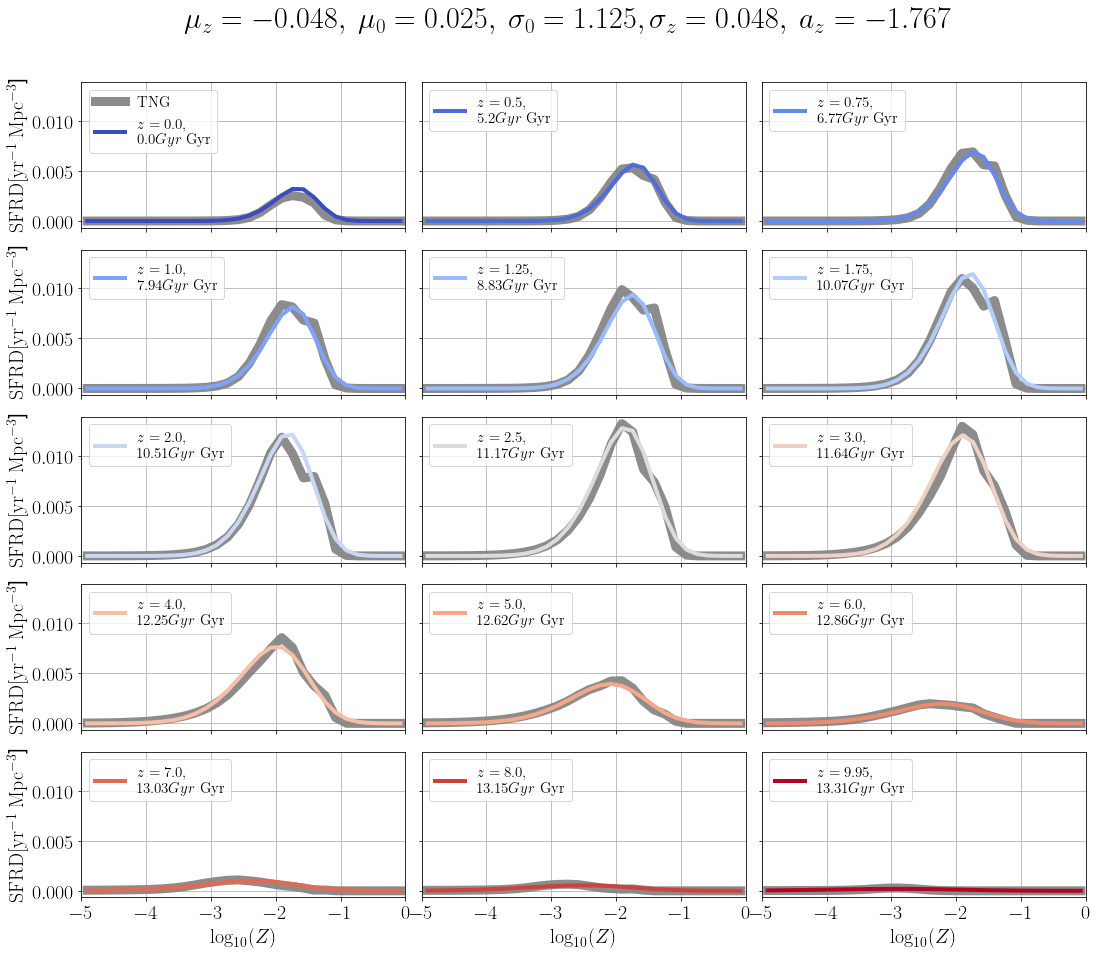

In [133]:

######################################
# BEST FITTING PARAMETERS:
print('\nBEST FITTING PARAMETERS:')
print('muz=%s, mu0=%s, sigma_0 =%s, sigma_z =%s, alpha=%s'% (muz_best, mu0_best, sigma0_best, sigmaz_best,alpha_best) )
print('\n')

######################################
normed = False

interpolated = True

######################################
if interpolated:
    # Use interpolated TNG
    print('Using interpolated TNG data')
    obs_redshift = z_new
    obs_metal = ynew
    obs_SFRD = SFRDnew.T
    redsfift_indces = [0,10,15,
                       20,25,35,
                       40,50,60,
                       80,100,120,
                       140,160,199]
else:
    # Use original TNG
    print('Using original TNG data')
    obs_redshift = redshifts_TNG[::-1]
    obs_metal = tofit_TNG_metals
    obs_SFRD = tofit_TNG_SFRD
    redsfift_indces = [0,8,15,32,40,48,58,60,66,70,75,80,88,91,95]


#####################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=obs_metal, redsh = obs_redshift)
t_lookback = cosmo.lookback_time(redshifts)
# print(['%.2f'% (z_fl) for  z_fl in redshifts ] )


#####################################
# Get the SFR
# sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 
# coen Madau_Dickinson2014(redshift_list,a=0.01, b=2.77, c=2.9, d=4.7 label = 'Neijssel et al 2019')
# sfr = Star_form

#####################################

colors     = plt.cm.coolwarm(np.linspace(0.,1.0, len(redsfift_indces))) #3rd num is the number of colours

######################################
# PLOT it!
# Draw the figure
FIG, ax = plt.subplots(nrows=5,ncols=3, figsize=(18,15), squeeze=False, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)#(20,28)

for z, redshift_i in enumerate(redsfift_indces):
    linestyles = ['-', ':', '--', '-.', ':']
    ######################################
    # "OBSERVATIONS" = TNG 
    ######################################
    row  = int(floor(z/3) )
    col  = z - row*3
    #print('row, col', row, col)
    
    if z == 0:
        LAB = "$\mathrm{TNG}$"
    else:
        LAB = None
    
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        obs_norm        = np.sum(obs_SFRD[redshift_i,:])
        normed_TNG_SFRD = obs_SFRD[redshift_i,:]/obs_norm
        ax[row,col].plot(np.log10(obs_metal), normed_TNG_SFRD, 
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB)   
        
    # Plot the full fit, including params for SFR(z)
    else:
        ax[row,col].plot(np.log10(obs_metal), obs_SFRD[redshift_i,:] ,
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB)    

    ######################################
    # MODEL = dPdlnZ * sfr(z)
    ######################################
    # Now the SFRD = sfr x dPdZ/p_draw_metallicity
    SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:] # Msun year-1 Mpc-3 

    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        # model is normed in log space, so multiply by log binwidth
        model = dPdlogZ[redshift_i,:] *step_logZ 
        ax[row,col].plot(np.log10(metallicities), model, lw = 4, ls = linestyles[0], c = colors[z],
                 label = "$z=%s,$ \n$%s$ $\mathrm{Gyr}$"%(np.round(redshifts[redshift_i],2), np.round(t_lookback[redshift_i],2) ) )    
    
    # Plot the full fit, including params for SFR(z)
    else:
        print('sfr[redshift_i]',sfr[redshift_i])
        ax[row,col].plot(np.log10(metallicities), SFRD, lw = 4, ls = linestyles[0], c = colors[z],
             label = "$z=%s,$ \n$%s$ $\mathrm{Gyr}$"%(np.round(redshifts[redshift_i],2), np.round(t_lookback[redshift_i],2) ) )    

    ax[row,col].legend(fontsize = 15, loc='upper left')
    ax[row,col].grid()
    
    ax[row,col].set_xlim(-5, 0.)

# #########################################
#PlotValues
for x in ax.flat:
    x.set(xlabel='$\log_{10}(Z)$', ylabel='$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for x in ax.flat:
    x.label_outer()
    
title = '$\mu_z=%s, \ \mu_0=%s, \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(muz_best,3),np.round(mu0_best,3),np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )
plt.suptitle(title, y = 0.95)

plt.show()


# at fixed metallicity


BEST FITTING PARAMETERS:
muz =-0.048244647721407255, mu0 =0.024667742078400792, sigma0 =1.1253850972905333,sigmaz =0.048072863682492945, alpha=-1.7671626767422142


Using interpolated TNG data
obs_metal [-4.90872016 -4.7420535  -4.57538683 -4.40872016 -4.2420535  -4.07538683
 -3.90872016 -3.7420535  -3.57538683 -3.40872016 -3.2420535  -3.07538683
 -2.90872016 -2.7420535  -2.57538683 -2.40872016 -2.2420535  -2.07538683
 -1.90872016 -1.7420535  -1.57538683 -1.40872016 -1.2420535  -1.07538683
 -0.90872016 -0.7420535  -0.57538683 -0.40872016 -0.2420535  -0.07538683]
(200,) (30,) (30, 200)


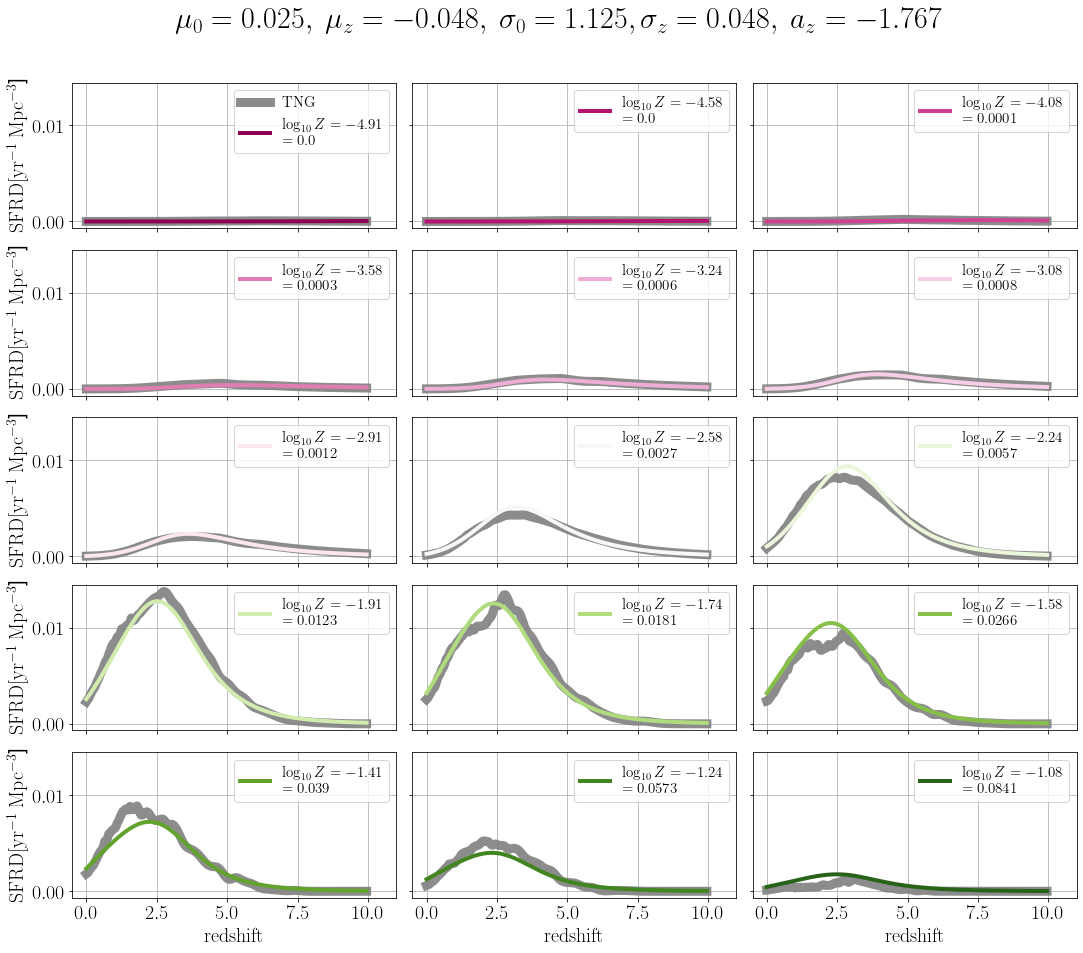

In [134]:

######################################
# BEST FITTING PARAMETERS:

print('\nBEST FITTING PARAMETERS:')
print('muz =%s, mu0 =%s, sigma0 =%s,sigmaz =%s, alpha=%s'% (muz_best,mu0_best,sigma0_best,sigmaz_best,alpha_best) )
print('\n')

######################################
normed       = False
interpolated = True

######################################
if interpolated:
    # Use interpolated TNG
    print('Using interpolated TNG data')
    obs_redshift = z_new
    obs_metal = ynew
    obs_SFRD = SFRDnew.T
    print('obs_metal' , np.log10(obs_metal) )
    print(np.shape(z_new), np.shape(ynew), np.shape(SFRDnew) )
#     metallicity_indces = [30, 32, 34, 36, 38, 40,42,44,46,48,50,52,54,56,58]
    metallicity_indces = [0,2,5,8,10,11,12,14,16,18,19,20,21,22,23]
    
else:
    # Use original TNG
    print('Using original TNG data')
    obs_redshift = redshifts_TNG[::-1]
    obs_metal = tofit_TNG_metals
    obs_SFRD = tofit_TNG_SFRD
    metallicity_indces = [0,2,5,8,10,11,12,14,16,18,19,20,21,22,23]

######################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=obs_metal, redsh = obs_redshift)

#####################################
# Get the SFR
sfr = Madau_Dickinson2014(obs_redshift, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 


#####################################
colors     = plt.cm.PiYG(np.linspace(0.,1.0, len(metallicity_indces))) #3rd num is the number of colours

######################################
# PLOT it!
# Draw the figure
FIG, ax = plt.subplots(nrows=5,ncols=3, figsize=(18,15), squeeze=False, sharex=True, sharey=True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)#(20,28)

for Z, metal_i in enumerate(metallicity_indces):

    linestyles = ['-', ':', '--', '-.', ':']
    row  = int(floor(Z/3) )
    col  = Z - row*3
    #print('row, col', row, col)
    
    if Z == 0:
        LAB = "$\mathrm{TNG}$"
    else:
        LAB = None
    
    ######################################
    # "OBSERVATIONS" = TNG np.log10(
    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        obs_norm        = np.sum(obs_SFRD[:,:], axis = -1)
        ax[row,col].plot(obs_redshift, obs_SFRD[:,metal_i]/obs_norm,
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB) 
    # Plot the full fit, including params for SFR(z)
    else:
        ax[row,col].plot(obs_redshift, obs_SFRD[:,metal_i],
                         lw = 9, c = 'grey', alpha = 0.9,label = LAB) 
        
    ######################################
    # MODEL = dPdlnZ * sfr(z)
    ######################################
    # Now the SFRD = sfr x dPdZ/p_draw_metallicity
    SFRD = sfr *dPdlogZ[:, metal_i]# Msun year-1 Mpc-3 

    ######################################
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed: 
        # model is normed in log space, so multiply by log binwidth
        ax[row,col].plot(obs_redshift, dPdlogZ[:,metal_i] *step_logZ , lw = 4, ls = linestyles[0], c = colors[Z],
                 label = "$\log_{10}Z=%s$ \n $=%s$"%(np.round(np.log10(metallicities[metal_i]),2),np.round(metallicities[metal_i],4) ) )    
    else:
        ax[row,col].plot(obs_redshift, SFRD.value, lw = 4, ls = linestyles[0], c = colors[Z],
                 label = "$\log_{10}Z=%s$ \n $=%s$"%(np.round(np.log10(metallicities[metal_i]),2),np.round(metallicities[metal_i],4) ) )    
        
        
    ######################################
    # PLOT PARAMS
    ax[row,col].legend(fontsize = 15, loc='upper right')
    ax[row,col].grid()
    
    ax[row,col].set_xlim(-0.5, 11)
#     ax[row,col].set_ylim(0, 0.015)
#     ax[row,col].set_ylim(-10, -1)

# #########################################
#PlotValues
for x in ax.flat:
    x.set(xlabel='$\mathrm{redshift}$', ylabel='$\mathrm{SFRD [yr^{-1}\ Mpc^{-3}}$]')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for x in ax.flat:
    x.label_outer()
    
title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )
plt.suptitle(title, y = 0.95)

plt.show()


# Plotting for presentation

 sf_a_best=0.01687063881834458, sf_b_best=1.4834054063851878, sf_c_best=4.448574027958166, sf_d_best=5.903964702985274
(200,) (100,) (100, 200)
Using interpolated TNG
saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefid.pdf


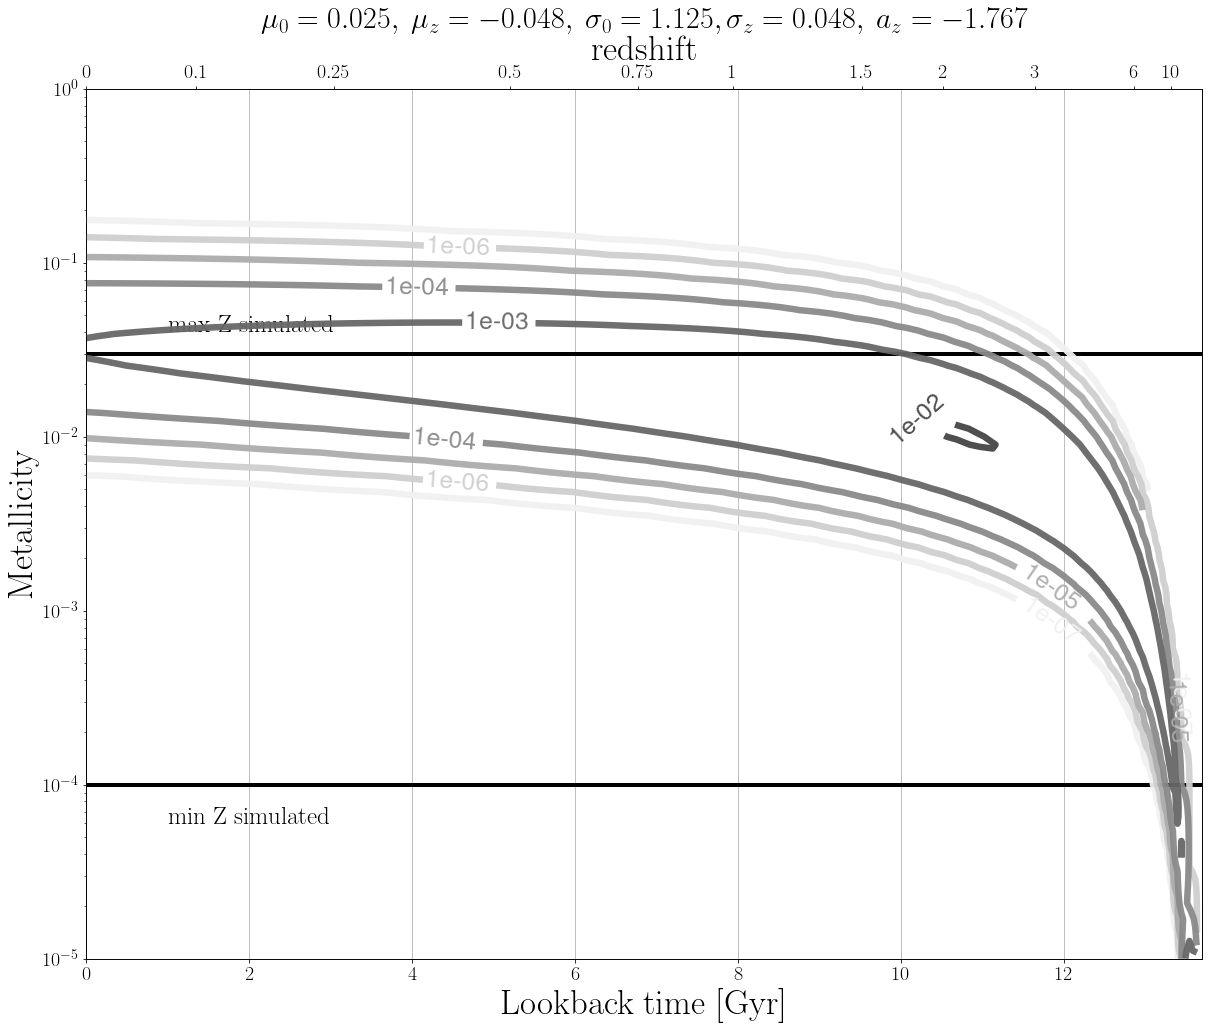

[ 0.          0.13658183  0.34030755  0.47534677  0.67671578  0.81015547
  1.00908311  1.14086723  1.33726997  1.46734342  1.66113951  1.85333323
  1.98055833  2.17001919  2.29539695  2.48204963  2.66698266  2.78930339
  2.97131465  3.15154078  3.27068859  3.50654754  3.62324616  3.79673883
  3.96834817  4.08169918  4.25012997  4.41663168  4.58118943  4.74378927
  4.90441867  5.06306637  5.21972221  5.37437747  5.52702452  5.72741947
  5.87535873  6.02127386  6.16516285  6.35386192  6.49302243  6.67542177
  6.80986482  6.98598935  7.11574095  7.28563467  7.45199472  7.61484448
  7.73469408  7.9301221   8.08261116  8.2317124   8.3774625   8.51990058
  8.69335341  8.82849234  8.99296052  9.15256312  9.30739418  9.5163257
  9.60313002  9.77192662  9.90779402 10.06523313 10.21673004 10.36246384
 10.52544101 10.68109903 10.82971687 10.97156926 11.12574783 11.27183568
 11.42698945 11.57291435 11.66532162 11.8666728  11.99903094 12.1225202
 12.27072847 12.34513494 12.44530365 12.52964511 12.6

In [196]:
######################################
# BEST FITTING PARAMETERS:
# (sfr: Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2)
####################################################
# Get dPdZ   

#NEIJSSEL
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=0.035, muz=-0.23,alpha = 0, 
                                              sigma_0=0.39, sigma_z =0, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = redshifts_TNG[::-1])
# and the SFR
sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9,  d=4.7) # Msun year-1 Mpc-3 


# # Updated
# dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
#                 skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
#                                               sigma_0=sigma0_best, sigma_z =sigmaz_best, 
#                                               min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
#                                               metals=tofit_TNG_metals, redsh = redshifts_TNG[::-1])
# # and the SFR
# sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 


print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)


#####################################
MSSFR = dPdlogZ.T *sfr
MSSFR = MSSFR.value
#/p_draw_metallicity # Msun year-1 Mpc-3 



Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

print(np.shape(xnew), np.shape(ynew), np.shape(SFRDnew))

# print(t_lookback,  metallicities, MSSFR.value)
metal_contours_TNG(x = t_lookback.value, y = metallicities, z =MSSFR, 
                   add_TNG = False, plot_contours = True, scatter = False, BBHcontour=False,
                   show_boundaries = True, boundkleur = 'k',
                   obs_redshift = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
#                    COMPASkleur="light:#fe1100", title = Title)
                   
                   COMPASkleur="light:#000000", title = Title)

print(t_lookback, metallicities, np.amax(SFRDnew.T) )

# MSSFR compared to TNG

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


 sf_a_best=0.01687063881834458, sf_b_best=1.4834054063851878, sf_c_best=4.448574027958166, sf_d_best=5.903964702985274
(200,) (30,) (30, 200)
Using interpolated TNG
saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefid.pdf


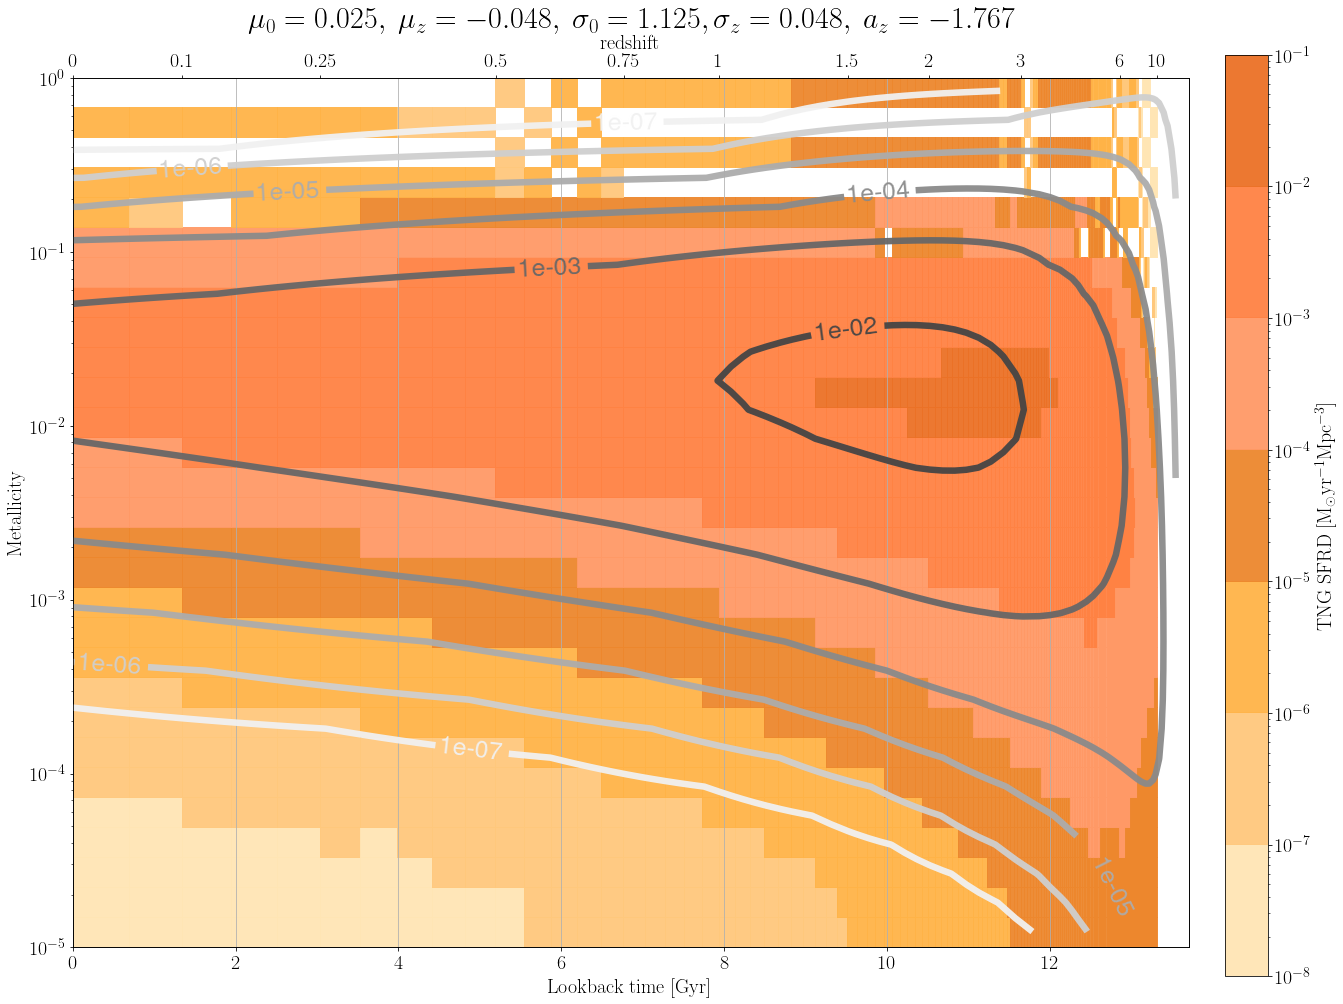

[ 0.          0.13658183  0.34030755  0.47534677  0.67671578  0.81015547
  1.00908311  1.14086723  1.33726997  1.46734342  1.66113951  1.85333323
  1.98055833  2.17001919  2.29539695  2.48204963  2.66698266  2.78930339
  2.97131465  3.15154078  3.27068859  3.50654754  3.62324616  3.79673883
  3.96834817  4.08169918  4.25012997  4.41663168  4.58118943  4.74378927
  4.90441867  5.06306637  5.21972221  5.37437747  5.52702452  5.72741947
  5.87535873  6.02127386  6.16516285  6.35386192  6.49302243  6.67542177
  6.80986482  6.98598935  7.11574095  7.28563467  7.45199472  7.61484448
  7.73469408  7.9301221   8.08261116  8.2317124   8.3774625   8.51990058
  8.69335341  8.82849234  8.99296052  9.15256312  9.30739418  9.5163257
  9.60313002  9.77192662  9.90779402 10.06523313 10.21673004 10.36246384
 10.52544101 10.68109903 10.82971687 10.97156926 11.12574783 11.27183568
 11.42698945 11.57291435 11.66532162 11.8666728  11.99903094 12.1225202
 12.27072847 12.34513494 12.44530365 12.52964511 12.6

In [107]:
######################################
# BEST FITTING PARAMETERS:
####################################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=tofit_TNG_metals, redsh = redshifts_TNG[::-1])

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

#####################################
# Get the SFR
# Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))
# sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 
sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 

MSSFR = sfr*dPdlogZ.T
#/p_draw_metallicity # Msun year-1 Mpc-3 

color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'


Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

print(np.shape(xnew), np.shape(ynew), np.shape(SFRDnew))

# print(t_lookback,  metallicities, MSSFR.value)
metal_contours_TNG(x = t_lookback.value, y = metallicities, z =MSSFR.value, plot_contours = True,
                   obs_redshift = xnew, obs_metal = ynew, obs_SFRD = SFRDnew,
                   COMPASkleur="light:#000000", title = Title)

print(t_lookback, metallicities, np.amax(SFRDnew.T) )

In [139]:

def metal_contours_TNG(x = None, y = None, z = None, normed = False,
                                tmin = 0.0, tmax = 13.7, 
                                obs_redshift = [], obs_metal = [], obs_SFRD = [],
                                DCO= None, DCO_mask = None, W_i = None,
                                param1 = 'fWR', p1 = 1.0, param2 = 'coolWind', p2 =1.0,
                                redshift_list = np.linspace(0,10, num=100),
                                boundkleur = 'orange',COMPASkleur = 'Oranges', 
                                TNGkleur = 'YlGnBu', scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma',
                                title = '', savestr ='fid',
                                min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                add_TNG = True, plot_contours = True, scatter = False, BBHcontour=False,
                                show_boundaries = False, show_obs = False, fid_contours=False):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    # Create the Figure
    fig, ax = plt.subplots(figsize = (20,16))
    
    ##############################################################################

    ######################################
    if len(obs_SFRD) == 0:
        print('Using original TNG')
        with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
            MetalBins     = 10**f["MetalBins"][:]
            Lookbacktimes = f["Lookbacktimes"][:]
            BoxSfr        = f["Sfr"][:]

        # Take the centers of the metallicity bins
        center_Zbin = np.log10((MetalBins[:-1] + MetalBins[1:])/2. )

        # Convert SFR from sfr/box to sfr Mpc-3
        littleh = 0.6774
        Rbox    = 75/littleh
        cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
        cosmic_SFR = cosmic_SFR.value
        cosmic_SFR = cosmic_SFR.T

    else:
        print('Using interpolated TNG')
        Lookbacktimes = obs_redshift
        center_Zbin   = obs_metal
        cosmic_SFR    = obs_SFRD
        
    if add_TNG:
        # construct cmap
        # orange - pink - green
    #     flatui = ['#dfe6cf', '#83AF9B','#C8C8A9','#F9CDAD','#FC9D9A','#F26B38','#de531f']

        flatui = ['#ffe5b4','#ffc87c', '#ffb347', '#ed872d', '#ff9966','#ff8243',  '#eb7126']#,'#e2725b']#'#ff8f00', '#e86100']
    #     flatui = ['#c9d4d6', '#b1bbbd', '#959fa1','#7b8385','#616769','#464b4d','#313638']
        tng_color = ListedColormap(sns.color_palette(flatui).as_hex())

        TNG = ax.pcolormesh(Lookbacktimes, center_Zbin, cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height],
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  


    ##############################################################################
    # YOUR dP/dZ MODEL
    ##############################################################################
    if plot_contours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)
        
        cs = ax.contour(x, y, z, levels, linewidths=6.5, cmap=COMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, zorder=10)
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')


    ##############################################################################
    # COMPA fiducial
    ##############################################################################
    if fid_contours:
        # Get dPdZ   
        fid_dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                        skew_metallicity_distribution(mu_0=0.035, muz=-0.23,alpha = 0, 
                                                      sigma_0=0.39, sigma_z =0, 
                                                      min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                                      metals=[], redsh = [])
        #Convert redshift to lookback time
        t_lookback = cosmo.lookback_time(redshifts)
        #####################################
        # Get the SFR Neijssel et al 2019: a=0.01, b=2.6, c=3.2,  d=6.2
        print(' sf_a_best=%s, sf_b_best=%s, sf_c_best=%s, sf_d_best=%s'%(sf_a_best, sf_b_best, sf_c_best, sf_d_best))
        fid_sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9, d=4.7) # Msun year-1 Mpc-3 
        fid_MSSFR = fid_sfr*fid_dPdlogZ.T
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        fidCOMPAS_cmap = sns.color_palette("Blues", as_cmap=True)
        
        cs = ax.contour(t_lookback, metallicities, fid_MSSFR, levels, linewidths=3.5, cmap=fidCOMPAS_cmap,
                         locator=ticker.LogLocator(), alpha = 0.95, )
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')

        
        
    ##############################################################################
    if show_boundaries:
        ######################################
        ## Show boundaries of COMPAS
        ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**min_logZ_COMPAS -4e-5, '$\mathrm{min \ Z \ simulated}$', color = boundkleur, size =25)

        ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**max_logZ_COMPAS+1e-2, '$\mathrm{max \ Z \ simulated}$', color = boundkleur, size =25)

    ##############################################################################
    if show_obs:
        obs_col = 'orange'
        ## Zsun
        ax.hlines(0.014*1.1, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, 0.014*1.1, '$Z=Z_{\odot}$', color = obs_col, va='bottom',size =25)

        ## LMC
        ax.hlines(0.014/2., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/2.)*1.1, '$\mathrm{LMC}$', color = obs_col, va='bottom', size =25)

        ## SMC
        ax.hlines(0.014/5., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/5.)*1.1, '$\mathrm{SMC}$', color = obs_col, va='bottom',size =25)

        ## Zw18
        ax.hlines(0.014/50., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/50.)*1.1, '$\mathrm{1 \ Zw \ 18}$', color = obs_col, va='bottom', size =25)
    ######################################
    # Scatter the mergning BBHs assuming they all merge at z = 0
    # from Myr to Gyr
    if scatter:
        DCO_mask = DCO_mask#*one_CE
        BBH = DCO[DCO_mask]
        Weight_mask = W_i > 1e-10
        print(len(BBH))
        scat = ax.scatter(BBH['tDelay'][Weight_mask]*1e-3, BBH['Metallicity@ZAMS(1)'][Weight_mask], 
                   label = 'COMPAS '+param1+str(p1)+param2+str(p2), s = W_i[Weight_mask]*300,
                   c=BBH['M_moreMassive'][Weight_mask], cmap = 'RdYlGn_r' ,vmin =2.5, vmax = 45)
        
        cbaxes1 = fig.add_axes([0.125, 0.0,0.8 , 0.02]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label='$M_{\mathrm{BH},1}$', orientation = 'horizontal')  
        #                facecolors='none', edgecolors=kleur) 
        ax.legend(loc ='lower left',markerscale=1)

    
#     ###################
#     #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_yscale('log')
    ax.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 35)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 35)
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, 10]
    # Find loockback location for each of our ages
    z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]
    
    # And annotate the tick labels :)
    ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
    ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
    ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 35)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
    
    plt.title(title)
    print('saving here', save_loc + 'RedshiftMetal_Plane'+savestr+'.pdf')
#     plt.savefig(save_loc + 'RedshiftMetal_Plane'+savestr+'.jpg',  bbox_inches='tight')
    
    plt.show()


# Same but in redshift space

In [199]:
                         
def metal_contours_TNG_zspace(x = None, y = None, z = None, normed = False,
                                tmin = 0.0, tmax = 13.7,
                              obs_redshift = [], obs_metal = [], obs_SFRD = [],
                                DCO= None, DCO_mask = None, W_i = None,
                                param1 = 'fWR', p1 = 1.0, param2 = 'coolWind', p2 =1.0,
                                redshift_list = np.linspace(0,10, num=100),
                                boundkleur = 'orange',COMPASkleur = 'Oranges', 
                                TNGkleur = 'YlGnBu', scatterKleur = 'RdYlGn_r', BBH_kleur = 'magma',
                                title = '', savestr ='fid',
                                min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03),
                                add_TNG = True, plot_contours = True, scatter = False, BBHcontour=False,
                                show_boundaries = False, show_obs = False):
    '''
    x, y, z             ---------------> redshift/lookback time, metallicities, dP/dZ
    tmin,tmax           ---------------> min and max time in Gyr to show as xlim 
    DCO, DCO_mask       ---------------> table of double compact objects, + mask of which to include in plot 
    redshift_list       ---------------> redshifts to use for SFR
    kleur, kleurlabel   ---------------> colour/colour label of contour
    savestr             ---------------> string added to save name of plot
    min_logZ_COMPAS     ---------------> min ln(metal) that ocurs in COMPAS
    max_logZ_COMPAS     ---------------> max ln(metal) that ocurs in COMPAS
    '''
    ######################################
    # Create the Figure
    fig, ax = plt.subplots(figsize = (20,16))
    
    ##############################################################################
    if add_TNG:
        ######################################
        if len(obs_SFRD) == 0:
            print('Using original TNG')
            with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
                MetalBins     = 10**f["MetalBins"][:]
                Lookbacktimes = f["Lookbacktimes"][:]
                BoxSfr        = f["Sfr"][:]

            # Take the centers of the metallicity bins
            center_Zbin = np.log10(np.log10((MetalBins[:-1] + MetalBins[1:])/2. ) )

            # Convert SFR from sfr/box to sfr Mpc-3
            littleh = 0.6774
            Rbox    = 75/littleh
            cosmic_SFR = BoxSfr / Rbox**3 *u.Mpc**-3
            cosmic_SFR = cosmic_SFR.value
            cosmic_SFR = cosmic_SFR.T
            
            #### TNG redshifts corresponding to these lookback times ### 
            # the last value of Lookbacktimes = 0, which is problematic for z calculation
            redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
            redshifts_TNG.append(0) # put redshift zero back at the end
            redshifts_TNG = np.array(redshifts_TNG)        

        else: 
            print('Using interpolated TNG')
            redshifts_TNG = obs_redshift
            center_Zbin   = obs_metal
            cosmic_SFR    = obs_SFRD    
            ax.set_yscale('log')
            
            
    # Plot the dist normed at each rerdshift (not SFR(z) dependent)
    if normed:
        norm_cosmic_SFR = np.sum(cosmic_SFR, axis = -1)
        cosmic_SFR = cosmic_SFR/norm_cosmic_SFR[:,np.newaxis]  
    
    # construct cmap
    flatui = ['#dfe6cf', '#83AF9B','#C8C8A9','#F9CDAD','#FC9D9A','#F26B38','#de531f']
    #Oranges
    flatui = ['#ffe5b4','#ffc87c', '#ffb347', '#ed872d', '#ff9966','#ff8243',  '#eb7126']#,'#e2725b']#'#ff8f00', '#e86100']

    tng_color = ListedColormap(sns.color_palette(flatui).as_hex())

    if add_TNG:
        TNG = ax.pcolormesh(redshifts_TNG, center_Zbin, cosmic_SFR, 
                            rasterized=True, norm=matplotlib.colors.LogNorm(vmin=1e-8,vmax=1e-1), 
                            cmap=tng_color, alpha=0.95 ) #matplotlib.cm.YlGnBu
        cbaxes1 = fig.add_axes([0.925, 0.1, 0.03, 0.8]) #[left, bottom, width, height],
        cb = plt.colorbar(TNG, cax = cbaxes1, label= r"$\mathrm{TNG \ SFRD \ [M_{\odot} yr^{-1} Mpc^{-3}]}$")  


    ##############################################################################
    if plot_contours:
        # Plot the contours of the metallicity density
        levels = [1e-7,1e-6, 1e-5, 1e-4,1e-3,1e-2,1e-1,1e0]#np.logspace(2, 10., 10+1)
        COMPAS_cmap = sns.color_palette(COMPASkleur, as_cmap=True)

        cs = ax.contour(x, y, z, levels, linewidths=6.5, cmap=COMPAS_cmap)
#                          locator=ticker.LogLocator(), alpha = 0.95, )
        ax.clabel(cs,inline=1,fontsize=25, levels = levels, use_clabeltext=True, fmt = '%.0e')


    ##############################################################################
    if show_boundaries:
        ######################################
        ## Show boundaries of COMPAS
        ax.hlines(np.e**min_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**min_logZ_COMPAS -4e-5, '$\mathrm{min \ Z \ simulated}$', color = boundkleur, size =25)

        ax.hlines(np.e**max_logZ_COMPAS, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = boundkleur, lw = 4, ls = '-')
        ax.text(1.,np.e**max_logZ_COMPAS+1e-2, '$\mathrm{max \ Z \ simulated}$', color = boundkleur, size =25)

    ##############################################################################
    if show_obs:
        obs_col = 'orange'
        ## Zsun
        ax.hlines(0.014*1.1, xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, 0.014*1.1, '$Z=Z_{\odot}$', color = obs_col, va='bottom',size =25)

        ## LMC
        ax.hlines(0.014/2., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/2.)*1.1, '$\mathrm{LMC}$', color = obs_col, va='bottom', size =25)

        ## SMC
        ax.hlines(0.014/5., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/5.)*1.1, '$\mathrm{SMC}$', color = obs_col, va='bottom',size =25)

        ## Zw18
        ax.hlines(0.014/50., xmin=0, xmax = 10,transform=ax.get_yaxis_transform(),
                   color = 'orange', lw = 4, ls = ':')
        ax.text(10, (0.014/50.)*1.1, '$\mathrm{1 \ Zw \ 18}$', color = obs_col, va='bottom', size =25)
    
    ######################################
    # Scatter the mergning BBHs assuming they all merge at z = 0
    # from Myr to Gyr
    if scatter:
        DCO_mask = DCO_mask#*one_CE
        BBH = DCO[DCO_mask]
        Weight_mask = W_i > 1e-10
        print(len(BBH))
        scat = ax.scatter(BBH['tDelay'][Weight_mask]*1e-3, BBH['Metallicity@ZAMS(1)'][Weight_mask], 
                   label = 'COMPAS '+param1+str(p1)+param2+str(p2), s = W_i[Weight_mask]*300,
                   c=BBH['M_moreMassive'][Weight_mask], cmap = 'RdYlGn_r' ,vmin =2.5, vmax = 45)
        
        cbaxes1 = fig.add_axes([0.125, 0.0,0.8 , 0.02]) #[left, bottom, width, height],
        cb = plt.colorbar(scat, cax = cbaxes1, label='$M_{\mathrm{BH},1}$', orientation = 'horizontal')  
        #                facecolors='none', edgecolors=kleur) 
        ax.legend(loc ='lower left',markerscale=1)

    
    ###################
    #Plotvalues
    ax.xaxis.grid(5) # vertical lines
    ax.set_xlabel('$\mathrm{redshift}$', fontsize = 40)
    ax.set_ylabel('$\mathrm{Metallicity}$', fontsize = 40)
    ax.set_yscale('log')
    
    ######################################
    #### Add redshift Axis ####
    ax2 = ax.twiny()

    # Find loockback location for each of our redshifts
    redshift_tick_list = [0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
    # And annotate the tick labels :)
    ax2.set_xticks([z for z in redshift_tick_list])
    ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
    ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    #Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    
    ax.set_ylim(1e-5, 1e0)
#     ax.set_ylim(-5, 0)
    
    plt.title(title)
    print('saving here', save_loc + 'RedshiftMetal_Plane'+savestr+'.pdf')
#     plt.savefig(save_loc + 'RedshiftMetal_Plane'+savestr+'.jpg',  bbox_inches='tight')
    
    plt.show()

    




# For presentation

/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefid.pdf


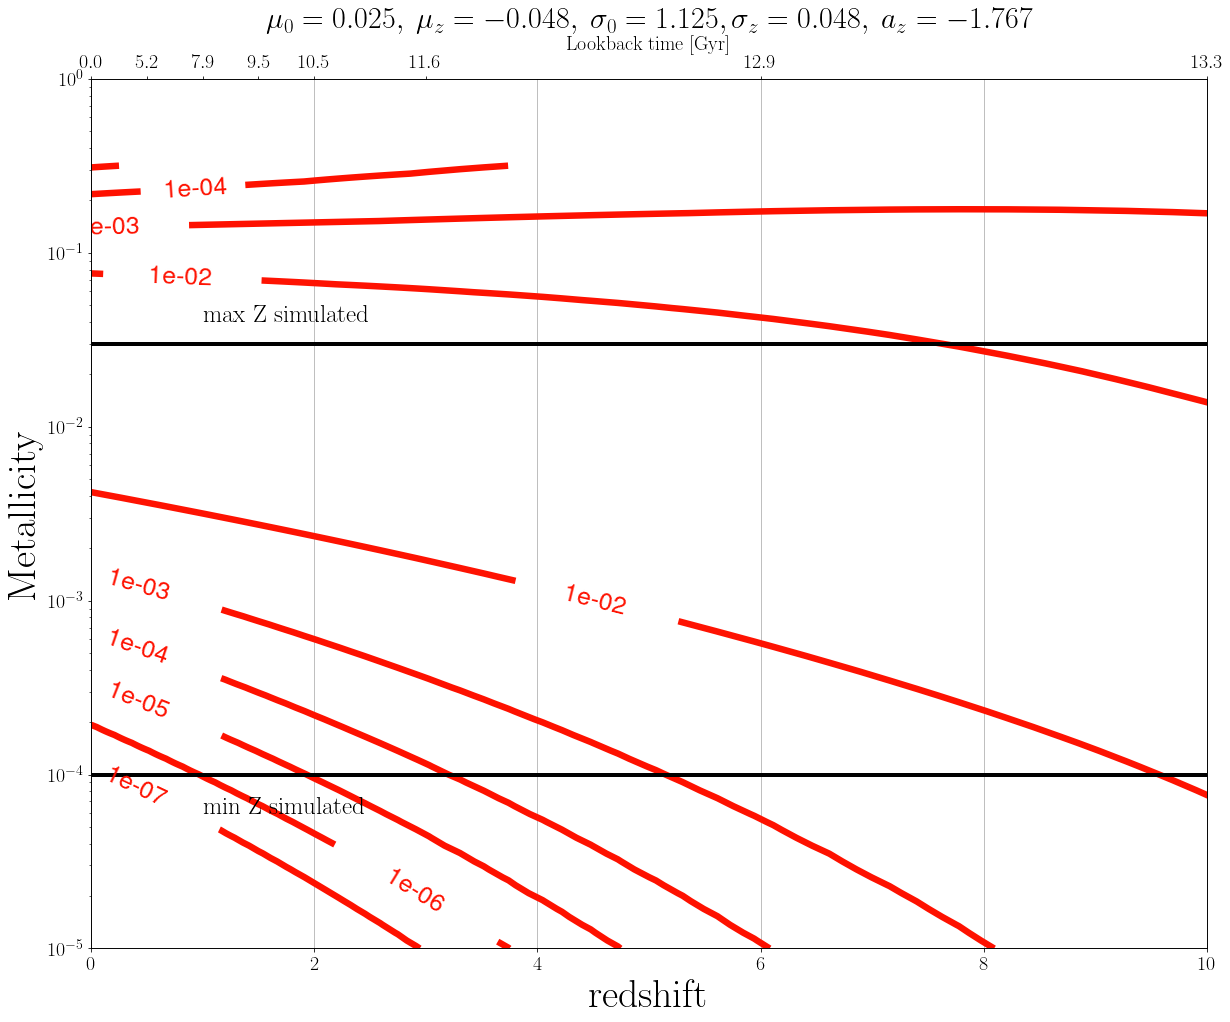

In [200]:
    
######################################
# BEST FITTING PARAMETERS:
####################################################
# Get dPdZ   

# #NEIJSSEL
# dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
#                 skew_metallicity_distribution(mu_0=0.035, muz=-0.23,alpha = 0, 
#                                               sigma_0=0.39, sigma_z =0, 
#                                               min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
#                                               metals=ynew, redsh = redshifts_TNG[::-1])
# # and the SFR
# sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9,  d=4.7) # Msun year-1 Mpc-3 


# Updated
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=ynew, redsh = redshifts_TNG[::-1])
# and the SFR
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)


#####################################
MSSFR = dPdlogZ.T #*sfr
# MSSFR = MSSFR.value
#/p_draw_metallicity # Msun year-1 Mpc-3 

#####
color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'
Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

metal_contours_TNG_zspace(x = redshifts, y = metallicities, z = MSSFR, 
                          add_TNG=False, plot_contours = True, scatter = False, 
                           show_boundaries = True, boundkleur = 'k',
                          BBHcontour=False,show_obs = False,
                          title = Title, tmin = 0.0, tmax = 10.,COMPASkleur = 'light:#fe1100_r', 
                          obs_redshift = z_new, obs_metal = ynew, obs_SFRD = SFRDnew,normed = False)



/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:76: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


Using interpolated TNG
saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefid.pdf


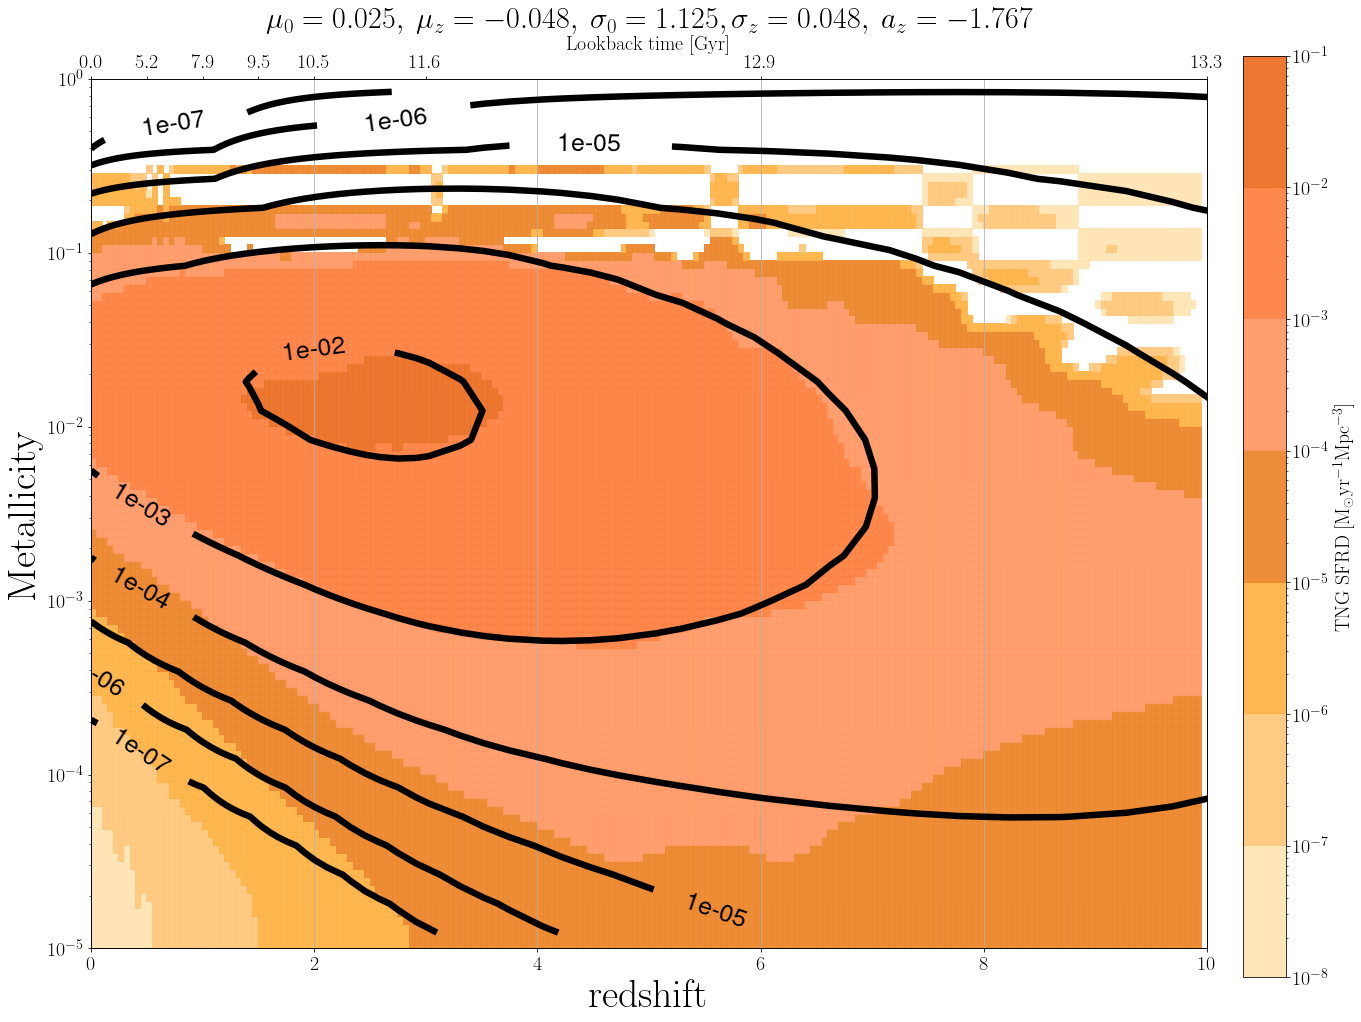

In [201]:
    
######################################
# BEST FITTING PARAMETERS:
####################################################
# Get dPdZ   
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=mu0_best, muz=muz_best,alpha = alpha_best, 
                                              sigma_0=sigma0_best, sigma_z =sigmaz_best, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                              metals=tofit_TNG_metals, redsh = redshifts_TNG[::-1])
#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

#####################################
# Get the SFR
# Madau & Fragos 2017: a=0.01, b=2.6, c=3.2,  d=6.2
sfr = Madau_Dickinson2014(redshifts, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best) # Msun year-1 Mpc-3 

MSSFR = sfr*dPdlogZ.T
#/p_draw_metallicity # Msun year-1 Mpc-3 

#####
color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'
Title = '$\mu_0=%s, \ \mu_z=%s,  \ \sigma_0=%s, \sigma_z=%s, \ a_z=%s$'%(np.round(mu0_best,3),np.round(muz_best,3), np.round(sigma0_best,3),np.round(sigmaz_best,3),np.round(alpha_best,3) )

metal_contours_TNG_zspace(x = redshifts, y = metallicities, z = MSSFR.value, add_TNG=True,
                          title = Title, tmin = 0.0, tmax = 10.,COMPASkleur = 'Greys_r', 
                          obs_redshift = z_new, obs_metal = ynew, obs_SFRD = SFRDnew,
                          plot_contours = True, normed = False)

# metal_contours_TNG_zspace(x = redshifts, y = metallicities, z =MSSFR ,savestr ='0.15',
#                         kleur = color_pallette,  title = Title, tmin = 0.0, tmax = 10.,
#                         kleurlabel = '$\mathrm{SSFRD \ [M_{\odot} \ Gpc^{-3}\ yr^{-1}]}$',
#                         plot_contours = True, normed = False)


max value of dPdlogZ 3.5007383759422166


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:51: UserWarning: The following kwargs were not used by contour: 'fontsize'


saving here /Users/lieke/surfdrive/Documents/CompareCOMPAS/plots/RedshiftMetal_Planefit.pdf


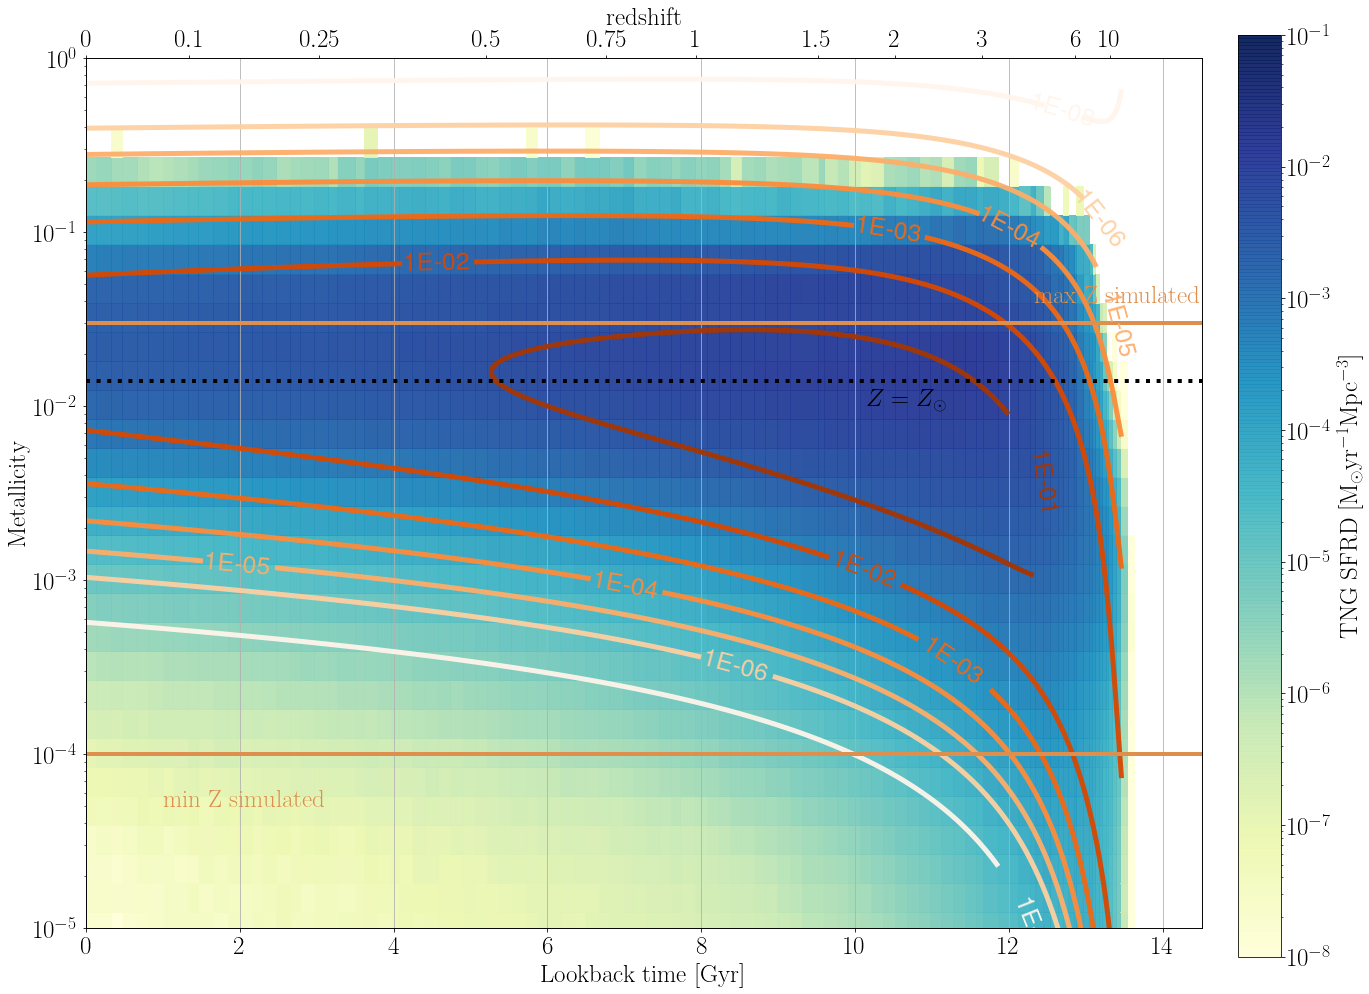

In [16]:
# Z0_fit, Pa_fit, sigma_fit, s_fact_fit = res[0]
# print('Z0_fit', np.round(Z0_fit,3), 'Pa_fit',  np.round(Pa_fit,3),
#       'sigma_fit',  np.round(sigma_fit,3), 's_fact_fit',  np.round(s_fact_fit,3) )
Z0_fit     = 0.025 # 0.025#0.035
Pa_fit     = -0.2#-0.095 #-0.23
sigma_fit  = 0.65 #0.39
s_fact_fit = 0.04#0.04


####################################################
# Get dPdZ 
dPdlogZ, redshifts, metallicities, p_draw_metallicity = get_metallicity_distribution(max_redshift = 13.0,redshift_step = 0.01,
                                 Z0=Z0_fit, alpha=Pa_fit, sigma=sigma_fit, s_factor = s_fact_fit)

print('max value of dPdlogZ', np.amax(dPdlogZ )/p_draw_metallicity )

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)

# Get the SFR
sfr = Madau_Dickinson2014(redshifts, a=0.01, d=4.7)# Msun year-1 Mpc-3 

MSSFR = sfr*dPdlogZ.T/p_draw_metallicity # Msun year-1 Mpc-3 

color_pallette = sns.light_palette('#543884', as_cmap=True, n_colors= 2)#colormap[1]'#543884'

metal_contours_TNG(x = t_lookback, y = metallicities, z =MSSFR ,savestr ='fit', 
                   scatter=False, kleur = color_pallette, kleurlabel = '$\mathrm{MSSFR \ [M_{\odot} \ yr^{-1}]}$'+ "$Z_0=%s$, $\mu_z=%s$, $\sigma=%s$"%(Z0, Pa, sigma) )




# calculatte chi squared by hand
###  Either by supplying a range of values and just taking the minimum 
### (this means you have to do the refinement part by hand)

In [ ]:
def skew_metallicity_distribution(max_redshift = 10.0,redshift_step = 0.01,
                                  mu_0=0.035, muz=-0.23, sigma=0.39, alpha = 0.0,
                                  min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.01,
                                  metals = [], redsh = [],
                                  min_logZ_COMPAS = np.log(1e-4),max_logZ_COMPAS = np.log(0.03)):
                                 
    """
    Calculate the distribution of metallicities at different redshifts using a log skew normal distribution
    that is basically a skew normal distribution, but then with the random variable x = ln(Z)

    NOTE: This assumes that metallicities in COMPAS are drawn from a flat in log distribution

    Args:
        max_redshift       --> [float]          max redshift for calculation
        redshift_step      --> [float]          step used in redshift calculation
        min_logZ_COMPAS    --> [float]          Minimum logZ value that COMPAS samples
        max_logZ_COMPAS    --> [float]          Maximum logZ value that COMPAS samples
        
        mu_0    = 0.035    --> [float]          location (mean in normal) for redshift 0
        muz = -0.23    --> [float]          redshift scaling of the location
        sigma   = 0.39     --> [float]          Scale (variance in normal)
        alpha   = 0.0      --> [float]          shape (skewness, alpha = 0 retrieves normal dist)

        min_logZ           --> [float]          Minimum logZ at which to calculate dPdlogZ
        max_logZ           --> [float]          Maximum logZ at which to calculate dPdlogZ
        step_logZ          --> [float]          Size of logZ steps to take in finding a Z range

    Returns:
        dPdlogZ            --> [2D float array] Probability of getting a particular logZ at a certain redshift
        metallicities      --> [list of floats] Metallicities at which dPdlogZ is evaluated
        p_draw_metallicity --> float            Probability of drawing a certain metallicity in COMPAS (float because assuming uniform)
    """
    import scipy
    ##################################
    # the PDF of a standard normal distrtibution
    def normal_PDF(x):
        return 1./(np.sqrt(2* np.pi)) * np.exp(-(1./2) * (x)**2 )

    ##################################
    # the CDF of a standard normal distrtibution
    def normal_CDF(x):
        return 1./2. * (1 + scipy.special.erf(x/np.sqrt(2)) )
    
    ##################################
    if len(redsh) == 0:
        # Make redshifts
        redshifts = np.arange(0, max_redshift + redshift_step, redshift_step)
    else:
        redshifts = redsh

    ##################################
    # Follow Langer & Norman in assuming that mean metallicities evolve in z as:
    mean_metallicities = 10**(muz * redshifts[:,np.newaxis])   # add an axis for muz
    mean_metallicities = mu_0 * mean_metallicities[:,:,np.newaxis] # add an axis for mu_0
        
    # Now we re-write the expected value of ou log-skew-normal to retrieve mu
    beta = alpha/(np.sqrt(1 + (alpha)**2))
    #print(10*'*', 'BETA', beta)
    PHI  = normal_CDF(beta * sigma[:,np.newaxis]) # phi is now sigma x alpha dimentional
    #print('np.shape(PHI)', np.shape(PHI))
    #print('np.shape(mean_metallicities)', np.shape(mean_metallicities), 'np.shape(sigma)', np.shape(sigma))
    #print(np.shape(1./(np.exp(0.5*sigma[:,np.newaxis]**2) * PHI) ) ) # this is now sigma x alpha dimentional
    
    mu_metallicities = np.log(mean_metallicities[:,:,:,np.newaxis,np.newaxis]/2. * 1./(np.exp(0.5*sigma[:,np.newaxis]**2) * PHI )  ) 
    #print('np.shape(mu_metallicities)', np.shape(mu_metallicities))

    ##################################
    if len(metals) == 0:
        # create a range of metallicities (thex-values, or raandom variables)
        log_metallicities = np.arange(min_logZ, max_logZ + step_logZ, step_logZ)
        metallicities = np.exp(log_metallicities)
    else: 
        #use a pre-determined array of metals
        metallicities     = metals
        log_metallicities = np.log(metallicities)
        step_logZ         = np.diff(log_metallicities)
        step_logZ         = step_logZ[0]
        print('step_logZ', step_logZ)

    ##################################
    # probabilities of log-skew-normal (without the factor of 1/Z since this is dp/dlogZ not dp/dZ)
    sigma_matrix = sigma[np.newaxis,np.newaxis,np.newaxis,:,np.newaxis,np.newaxis] # 1, 1,1, __sigma__, 1 ,1
    #print('np.shape(sigma_matrix)', np.shape(sigma_matrix))

    alpha_matrix = alpha[np.newaxis,np.newaxis,np.newaxis,np.newaxis,:,np.newaxis] # 1, 1,1, 1, __alpha__ ,1
    #print('np.shape(alpha_matrix)', np.shape(alpha_matrix))
    mu_matrix    = mu_metallicities[:,:,:,:,:,np.newaxis] # dimension is now redshift, mu_z,mu0, sigma, alpha + metallicity
    
    dPdlogZ = 2./(sigma_matrix) * normal_PDF((log_metallicities -  mu_matrix)/sigma_matrix) * normal_CDF(alpha_matrix * (log_metallicities -  mu_matrix)/sigma_matrix )


    ##################################
    # normalise the distribution over al metallicities
    norm = dPdlogZ.sum(axis=-1) #* step_logZ
    dPdlogZ = dPdlogZ / norm[:,:,:,:,:,np.newaxis]
    #print('NORMING', np.sum(dPdlogZ, axis = -1 )*step_logZ  )
    print('np.shape(dPdlogZ)', np.shape(dPdlogZ))

    ##################################
    # assume a flat in log distribution in metallicity to find probability of drawing Z in COMPAS
    p_draw_metallicity = 1 / (max_logZ_COMPAS - min_logZ_COMPAS)
    
    return dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity



In [213]:
muz_List = np.arange(-0.3, -0.05+0.01,  0.01)#np.array([-0.06, -0.07,-0.075,-0.080,-0.085, -0.09, -0.1])
mu_0_List    = np.array([0.02,0.024, 0.025,0.026,0.027,0.03])#np.arange(0.01, 0.04,  0.005)
sigma_List   = np.arange(0.5, 2.5+0.1, 0.1)#np.array([1.8, 1.85, 1.9,1.92,1.93,1.94, 1.95,1.96, 2.0,2.1])
alpha_List   = np.arange(-4, -0.5+0.1, 0.1)#np.array([-3.7, -3.65, -3.6, -3.55, -3.5,-3.4,-3.3])#np.arange(-4, -2, 0.05)


#####################################
# Get the SFR
# sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
# coen Madau_Dickinson2014(redshift_list,a=0.01, b=2.77, c=2.9, d=4.7 label = 'Neijssel et al 2019')
Star_form = Madau_Dickinson2014(redshifts, a=0.01, b=2.1, c=3.3,  d=5.6) # Msun year-1 Mpc-3 

##############################################################
# Start calculating Chi squared
##############################################################    
chi_square_matix, muz_best, mu_0_best, sigma_best, alpha_best = \
            calc_chi_square(fit_metals = tofit_TNG_metals, observed_SFRD = tofit_TNG_SFRD, 
                            redshifts = redshifts_TNG[::-1], normed=False, SFR = Star_form,
                            muz_list = muz_List, mu_0_list = mu_0_List,
                            sigma_list = sigma_List, alpha_list = alpha_List)
    
    

********** BETA [-0.9701425  -0.96866387 -0.96707454 -0.96536339 -0.96351791 -0.96152395
 -0.9593655  -0.9570244  -0.95447998 -0.95170862 -0.9486833  -0.94537298
 -0.94174191 -0.93774876 -0.93334561 -0.92847669 -0.92307692 -0.91707006
 -0.91036648 -0.90286052 -0.89442719 -0.88491822 -0.87415728 -0.86193422
 -0.8479983  -0.83205029 -0.81373347 -0.79262399 -0.76822128 -0.73994007
 -0.70710678 -0.66896473 -0.62469505 -0.57346234 -0.51449576 -0.4472136 ]
np.shape(PHI) (21, 36)
np.shape(mean_metallicities) (100, 26, 6) np.shape(sigma) (21,)
(21, 36)
np.shape(mu_metallicities) (100, 26, 6, 21, 36)
step_logZ 0.3837641821656739
np.shape(sigma_matrix) (1, 1, 1, 21, 1, 1)
np.shape(alpha_matrix) (1, 1, 1, 1, 36, 1)


/Users/lieke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:95: RuntimeWarning: invalid value encountered in true_divide


np.shape(dPdlogZ) (100, 26, 6, 21, 36, 30)
(100, 26, 6, 21, 36, 30)
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model has 0-values in it!
ERROR, your model ha

# SFR(z) Madau & Dickenson 2014 shape

you probably havent run the optimzation yet..


NameError: name 'skew_metallicity_distribution' is not defined

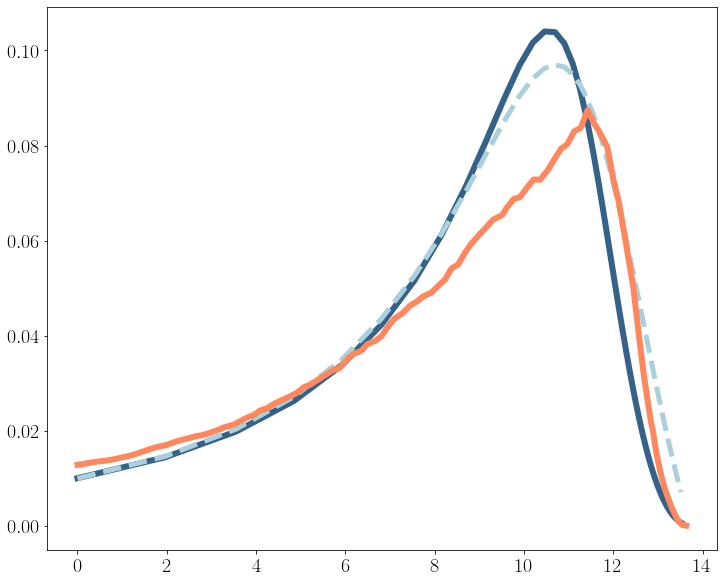

In [4]:

########################################################
# plot different SFRs
########################################################
def plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 13.7):
    ########################################################
    # Start plotting
    fig, ax = plt.subplots(figsize=(12,10))

    if x_redshift:
        x1  = redshift_list
    else:
        x1 = cosmo.lookback_time(redshift_list)


#     #default M&D 14
#     ax.plot(x1, Madau_Dickinson2014(redshift_list), 
#              label = 'Madau $\&$ Dickinson 2014\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.015,2.77,2.9,5.6)
#              , c = 'royalblue', ls = '--',lw=2)

    #default Madau & Fragos 17
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.6, c=3.2, d=6.2), 
             label = 'Madau $\&$ Fragos 2017\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.6,3.2,6.2)
             , c = '#356288', ls = '-',lw=6)

    #default Coen
    ax.plot(x1, Madau_Dickinson2014(redshift_list, a=0.01, b=2.77, c=2.9, d=4.7), 
             label = 'Neijssel et al 2019\n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (0.01,2.77,2.9,4.7)
             , c = '#aacfdd', lw=5, ls = '--')


    # BEST FIT
    try:
        y_vals = Madau_Dickinson2014(redshift_list, a=sf_a_best, b=sf_b_best, c=sf_c_best,  d=sf_d_best)
        ax.plot(x1, y_vals,label = 'Using best fit parameters \n $a=%.2f, b=%.2f, c=%.2f, d=%.2f$'% (sf_a_best,sf_b_best,sf_c_best, sf_d_best), 
                 c = '#fe1100', lw=5, ls = '--', zorder =10)
        print('max value', y_vals[np.argmax(y_vals)], ' at x_max = ', x1[np.argmax(y_vals)])
    except:
        print('you probably havent run the optimzation yet..')



    ######################################
    # read TNG data
    ######################################
    with h5.File(TNGlocation+"SFRMetallicityFromGasTNG100.hdf5", "r") as f:
        MetalBins     = f["MetalBins"][:]
        Lookbacktimes = f["Lookbacktimes"][:]
        BoxSfr        = f["Sfr"][:]
    # Convert SFR from sfr/box to sfr Mpc-3
    littleh  = 0.6774
    Rbox     = 75/littleh
    TNG_SFRD = BoxSfr / Rbox**3 *u.Mpc**-3
    TNG_SFRD = TNG_SFRD.value
    # the last value of Lookbacktimes = 0, which is problematic for z calculation
    redshifts_TNG = [z_at_value(cosmo.lookback_time,t*u.Gyr) for t in Lookbacktimes[:-1]] 
    redshifts_TNG.append(0) # put redshift zero back at the end
    redshifts_TNG = np.array(redshifts_TNG)
    redshifts_TNG_inc = redshifts_TNG[::-1]
    ##########################################
    # "observed" TNG SFR(z)
    ##########################################
    if x_redshift:
        xobs  = redshifts_TNG
    else:
        xobs = Lookbacktimes

    ax.plot(xobs, np.sum(TNG_SFRD,axis=1), label = 'TNG', c = '#fe875d', lw=6)

    # #######################
    # # Interpolated
    # x = Lookbacktimes #redshifts_TNG[::-1]
    # y = center_Zbin
    # z = TNG_SFRD # shape [increasing redshift, metal]
    # f_interp = interpolate.interp2d(x, y, z.T, kind='cubic')
    # # lets interpolate at regular z intervals
    # z_new    = np.arange(0, 10, 0.1)
    # xnew     = [cosmo.lookback_time(z).value for z in z_new]
    # ynew     = center_Zbin#np.logspace(-5, -0.5, num=50)

    # SFRDnew = f_interp(xnew,ynew)
    # print('np.shape(SFRDnew)', np.shape(SFRDnew) )
    # ax.plot(xnew, np.sum(SFRDnew,axis=0), label = 'TNG', c = 'green', lw=5, ls='--')


    ##########################################
    # Checking normalization of what I will fit
    ##########################################################################
    center_Zbin = (MetalBins[:-1] + MetalBins[1:])/2.
    sfr = Madau_Dickinson2014(redshifts_TNG_inc, a=0.01, b=2.6, c=3.2,  d=6.2) # Msun year-1 Mpc-3 
    # Get dPdZ 
    dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                    skew_metallicity_distribution(muz =-0.1, mu_0 =0.025,
                                                  sigma_0=1.9,sigma_z=1.9, alpha =-1.7, 
                                                  metals=center_Zbin, redsh = redshifts_TNG_inc)
    if x_redshift:
        x  = redshifts
    else:
        x = cosmo.lookback_time(redshifts)

    # For each redshift in the TNG data:
    for redshift_i in range(len(redshifts)):
        SFRD = sfr[redshift_i] *dPdlogZ[redshift_i,:]#* step_logZ
#         plt.scatter(x[redshift_i], np.sum(SFRD), c = 'r')
        #
    ##########################################################################


    #### Age Universe Axis ####
    ax2 = ax.twiny()

    if x_redshift:
        ###################
        #Plotvalues
        ax.set_xlabel('$\mathrm{redshift}$', fontsize = 30)

        # Find loockback location for each of our redshifts
        redshift_tick_list = [0, 0.5, 2, 3, 6, 10, 12]#[0, 0.5, 1.0, 1.5, 2, 3, 6, 10, 12]
        # And annotate the tick labels :)
        ax2.set_xticks([z for z in redshift_tick_list])
        ax2.set_xticklabels(['${:.1f}$'.format(cosmo.lookback_time(z).value) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 20)

    else:
        ###################
        #Plotvalues
        ax.set_xlabel(r'$\mathrm{Lookback \ time \ [Gyr]}$', fontsize = 30)
        
        redshift_tick_list = [0,0.1, 0.25, 0.5, 0.75, 1.0,1.5, 2, 3, 6, ]
        # Find loockback location for each of our ages
        z_ticks = [cosmo.lookback_time(z) for z in redshift_tick_list]

        # And annotate the tick labels :)
        ax2.set_xticks([cosmo.lookback_time(z).value for z in redshift_tick_list])
        ax2.set_xticklabels(['${:g}$'.format(z) for z in redshift_tick_list])
        ax2.set_xlabel('$\mathrm{redshift}$', fontsize = 30)


    ##########################################################################
    ax.xaxis.grid(5) # vertical lines
    # Make sure top and bottom axis are lined up (have same limmits)
    ax.set_xlim(tmin, tmax)
    ax2.set_xlim(tmin, tmax)
    logy = True
    if logy:
        plt.yscale('log')
    ax.set_ylabel(r'$\frac{dM}{dt dV_c}$ $\mathrm{[M_{\odot} yr^{-1} Mpc^{-3}]}$', fontsize = 30)
    ax.set_ylim(1e-3, 0.2)
    ax.legend()
    if x_redshift:
        print('saving here', save_loc + 'SFR_redshift'+'.pdf')
        plt.savefig(save_loc + 'SFR_redshift'+'.pdf',  bbox_inches='tight')
    else:
        print('saving here', save_loc + 'SFR_tlookback'+'.pdf')
        plt.savefig(save_loc + 'SFR_tlookback'+'.pdf',  bbox_inches='tight')
    
    plt.show()

    
# time axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = False, tmin=0.0, tmax = 13.7)

# redshift axis
plot_SFR(redshift_list  = np.linspace(0,15, num=100), x_redshift = True, tmin=0.0, tmax = 15)


In [ ]:
sf_a_best, sf_b_best, sf_c_best,  sf_d_best = 0.02, 1.48, 4.45, 5.90
# sf_a =0.01687063881834458, sf_b =1.4834054063851878, sf_c =4.448574027958166, sf_d =5.903964702985274

# muz =-0.048244647721407255, mu0 =0.024667742078400792, sigma_0 =1.1253850972905333, sigma_z =0.048072863682492945, alpha=-1.7671626767422142


In [17]:
####################################################
# Get dPdZ   

#NEIJSSEL
dPdlogZ, redshifts, metallicities, step_logZ, p_draw_metallicity = \
                skew_metallicity_distribution(mu_0=0.035, muz=-0.23,alpha = 0, 
                                              sigma_0=0.39, sigma_z =0, 
                                              min_logZ  =-12.0, max_logZ  =0.0, step_logZ = 0.5,
                                              metals=ynew, redsh = redshifts_TNG[::-1])
#                                               metals=ynew, redsh = redshifts_TNG[::-1])
# and the SFR
sfr = Madau_Dickinson2014(redshifts, a=0.01, b=2.77, c=2.9,  d=4.7) # Msun year-1 Mpc-3 

#Convert redshift to lookback time
t_lookback = cosmo.lookback_time(redshifts)


#####################################
MSSFR = dPdlogZ.T *sfr
# MSSFR = MSSFR.value


print(np.amax(MSSFR.to(u.Msun/(u.Gpc**3 * u.yr) )))

37276787.887857914 solMass / (Gpc3 yr)


In [23]:
6./(0 - np.log(10**(-12) ))

0.2171472409516259